In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Define the tickers and date range
tickers = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-B', 'JPM', 'V']
start_date = '2010-01-01'
end_date = '2021-12-31'
train_end_date = '2019-12-31'
test_start_date = '2020-01-01'

# Dictionary to store historical data and predictions
stock_data = {}
all_predictions = {}
evaluation_metrics = {}

# 2. Download daily historical stock price data
print("Downloading historical stock data...")
for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if not data.empty:
            stock_data[ticker] = data['Close'].dropna()
            print(f"Successfully downloaded data for {ticker}. Rows: {len(stock_data[ticker])}")
        else:
            print(f"No data downloaded for {ticker}. Skipping.")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

print("\n--- Data Download Complete ---")

# 3. Data Preparation and Model Building for each stock
print("\nBuilding and evaluating models for each stock...")

for ticker, df_close in stock_data.items():
    print(f"\nProcessing {ticker}...")

    # Ensure the index is a DatetimeIndex
    df_close.index = pd.to_datetime(df_close.index)

    # Split data into training and testing sets
    train_data = df_close[df_close.index <= train_end_date]
    test_data = df_close[(df_close.index >= test_start_date) & (df_close.index <= end_date)]

    if train_data.empty or test_data.empty:
        print(f"Skipping {ticker} due to insufficient training or testing data.")
        continue

    # Store actual values for plotting
    actual_prices = test_data.copy()
    stock_predictions = {}
    stock_eval_metrics = {}

    # --- ARIMA Model ---
    print(f"  Training ARIMA for {ticker}...")
    try:
        # Auto-ARIMA or manual order selection (simplified for this example)
        # A common approach for 'd' is to check for stationarity using ADF test.
        # For 'p' and 'q', ACF/PACF plots are used.
        # Here, we'll try a common (1,1,1) order or find a suitable one if it fails.
        arima_order = (5, 1, 0) # (AR, I, MA) - often (p,1,0) for financial data
        model_arima = ARIMA(train_data, order=arima_order)
        model_arima_fit = model_arima.fit()
        arima_forecast = model_arima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
        arima_forecast.index = test_data.index
        stock_predictions['ARIMA'] = arima_forecast.fillna(method='ffill').fillna(method='bfill') # Handle potential NaNs
        rmse_arima = np.sqrt(mean_squared_error(test_data, arima_forecast))
        stock_eval_metrics['ARIMA'] = rmse_arima
        print(f"    ARIMA RMSE: {rmse_arima:.2f}")
    except Exception as e:
        print(f"    ARIMA model failed for {ticker}: {e}")
        stock_eval_metrics['ARIMA'] = float('inf') # Set to infinity to indicate failure

    # --- Prophet Model ---
    print(f"  Training Prophet for {ticker}...")
    try:
        # Prophet requires specific column names 'ds' (datestamp) and 'y' (value)
        # Reset index to get dates as a column, then create proper DataFrame
        train_df_reset = train_data.reset_index()
        prophet_train_df = pd.DataFrame({
            'ds': pd.to_datetime(train_df_reset.iloc[:, 0]),  # First column is the date
            'y': train_df_reset.iloc[:, 1].astype(float)      # Second column is the close price
        })

        # Remove any potential NaN values
        prophet_train_df = prophet_train_df.dropna()

        model_prophet = Prophet(daily_seasonality=True,
                              yearly_seasonality=True,
                              weekly_seasonality=False,  # Reduced complexity
                              changepoint_prior_scale=0.05,
                              interval_width=0.95) # Add some regularization
        model_prophet.fit(prophet_train_df)

        # Create future dataframe for prediction period
        # Get all business days in the test period
        future_dates = pd.date_range(start=test_data.index.min(),
                                   end=test_data.index.max(),
                                   freq='B')  # Business days only
        future = pd.DataFrame({'ds': future_dates})

        prophet_forecast = model_prophet.predict(future)

        # Extract predictions and create series
        prophet_predictions = prophet_forecast[['ds', 'yhat']].set_index('ds')['yhat']

        # Align with test data index (handle missing dates)
        prophet_forecast_aligned = prophet_predictions.reindex(test_data.index, method='nearest')

        # Fill any remaining NaN values
        prophet_forecast_aligned = prophet_forecast_aligned.fillna(method='ffill').fillna(method='bfill')

        stock_predictions['Prophet'] = prophet_forecast_aligned
        rmse_prophet = np.sqrt(mean_squared_error(test_data, prophet_forecast_aligned))
        stock_eval_metrics['Prophet'] = rmse_prophet
        print(f"    Prophet RMSE: {rmse_prophet:.2f}")
    except Exception as e:
        print(f"    Prophet model failed for {ticker}: {e}")
        stock_eval_metrics['Prophet'] = float('inf')

    # --- LSTM Model ---
    print(f"  Training LSTM for {ticker}...")
    try:
        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
        scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

        # Create sequences for LSTM
        def create_sequences(data, seq_length):
            X, y = [], []
            for i in range(len(data) - seq_length):
                X.append(data[i:(i + seq_length), 0])
                y.append(data[i + seq_length, 0])
            return np.array(X), np.array(y)

        sequence_length = 60 # Number of past days to consider
        X_train, y_train = create_sequences(scaled_train_data, sequence_length)
        X_test, y_test = create_sequences(scaled_test_data, sequence_length)

        # Reshape for LSTM input: [samples, timesteps, features]
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        # Build LSTM model
        model_lstm = Sequential()
        model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
        model_lstm.add(LSTM(units=50))
        model_lstm.add(Dense(units=1))
        model_lstm.compile(optimizer='adam', loss='mean_squared_error')

        # Train LSTM model
        model_lstm.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)

        # Make predictions
        lstm_predictions_scaled = model_lstm.predict(X_test)
        lstm_forecast = scaler.inverse_transform(lstm_predictions_scaled)

        # Align LSTM predictions with test_data index
        # LSTM predictions will be shorter due to sequence length
        # Need to align based on the number of predictions made
        start_idx = len(test_data) - len(lstm_forecast)
        lstm_forecast_series = pd.Series(lstm_forecast.flatten(), index=test_data.index[start_idx:])
        stock_predictions['LSTM'] = lstm_forecast_series.fillna(method='ffill').fillna(method='bfill')
        rmse_lstm = np.sqrt(mean_squared_error(test_data.iloc[start_idx:], lstm_forecast))
        stock_eval_metrics['LSTM'] = rmse_lstm
        print(f"    LSTM RMSE: {rmse_lstm:.2f}")

    except Exception as e:
        print(f"    LSTM model failed for {ticker}: {e}")
        stock_eval_metrics['LSTM'] = float('inf')

    # Store all model predictions for comparison
    all_model_predictions = {}
    for model_name, prediction in stock_predictions.items():
        all_model_predictions[model_name] = prediction

    # Determine the best model for the current stock
    best_model_name = min(stock_eval_metrics, key=stock_eval_metrics.get)
    best_model_rmse = stock_eval_metrics[best_model_name]

    if best_model_rmse == float('inf'):
        print(f"  No successful model for {ticker}.")
        all_predictions[ticker] = None # Mark as failed
        evaluation_metrics[ticker] = {'Best Model': 'None', 'RMSE': float('inf'), 'All Models': stock_eval_metrics}
    else:
        print(f"  Best model for {ticker}: {best_model_name} with RMSE: {best_model_rmse:.2f}")
        all_predictions[ticker] = {
            'Actual': actual_prices,
            'Predicted': stock_predictions[best_model_name],
            'All Predictions': all_model_predictions,
            'Best Model': best_model_name
        }
        evaluation_metrics[ticker] = {
            'Best Model': best_model_name,
            'RMSE': best_model_rmse,
            'All Models': stock_eval_metrics
        }

print("\n--- Model Training and Evaluation Complete ---")

# 4. Generate and save charts
print("\nGenerating charts...")
for ticker, data_info in all_predictions.items():
    if data_info is None:
        print(f"Skipping chart for {ticker} due to failed model training.")
        continue

    actual = data_info['Actual']
    predicted = data_info['Predicted']
    all_preds = data_info['All Predictions']
    best_model = data_info['Best Model']

    plt.figure(figsize=(16, 10))

    # Main plot
    plt.subplot(2, 1, 1)
    plt.plot(actual.index, actual, label='Actual Closing Price', color='blue', linewidth=2)
    plt.plot(predicted.index, predicted, label=f'Best Predicted ({best_model})', color='red', linestyle='--', linewidth=2)
    plt.title(f'{ticker} - Actual vs. Best Predicted Closing Prices (2020-2021) - Best Model: {best_model}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)

    # Comparison of all models
    plt.subplot(2, 1, 2)
    plt.plot(actual.index, actual, label='Actual', color='blue', linewidth=2)
    colors = ['red', 'green', 'orange']
    for i, (model_name, model_pred) in enumerate(all_preds.items()):
        if model_pred is not None and len(model_pred) > 0:
            plt.plot(model_pred.index, model_pred,
                    label=f'{model_name} (RMSE: {evaluation_metrics[ticker]["All Models"][model_name]:.2f})',
                    color=colors[i % len(colors)], linestyle='--', alpha=0.7)

    plt.title(f'{ticker} - Comparison of All Models')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    chart_filename = f'{ticker}_stock_prediction.png'
    plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Chart saved for {ticker} as {chart_filename}")

print("\n--- All Charts Generated ---")
print("\nDetailed Summary of All Models and RMSE:")
for ticker, metrics in evaluation_metrics.items():
    print(f"\n{ticker}:")
    print(f"  Best Model: {metrics['Best Model']}")
    if 'All Models' in metrics:
        for model_name, rmse in metrics['All Models'].items():
            if rmse != float('inf'):
                print(f"  {model_name}: RMSE = {rmse:.2f}")
            else:
                print(f"  {model_name}: FAILED")

[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for AAPL. Rows: 3020



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for MSFT. Rows: 3020


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for NVDA. Rows: 3020
Successfully downloaded data for AMZN. Rows: 3020


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GOOGL. Rows: 3020
Successfully downloaded data for META. Rows: 2421
Successfully downloaded data for TSLA. Rows: 2898


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for BRK-B. Rows: 3020



[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for JPM. Rows: 3020


Successfully downloaded data for V. Rows: 3020

--- Data Download Complete ---

Building and evaluating models for each stock...

Processing AAPL...
  Training ARIMA for AAPL...
    ARIMA RMSE: 52.81
  Training Prophet for AAPL...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/3ty32oso.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/kozj55um.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86851', 'data', 'file=/tmp/tmpuv7qm7qf/3ty32oso.json', 'init=/tmp/tmpuv7qm7qf/kozj55um.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_modelale48dhl/prophet_model-20250527065759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:57:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 57.36
  Training LSTM for AAPL...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
    LSTM RMSE: 8.11
  Best model for AAPL: LSTM with RMSE: 8.11

Processing MSFT...
  Training ARIMA for MSFT...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/s1s0upam.json


    ARIMA RMSE: 90.89
  Training Prophet for MSFT...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/e37yaodf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21529', 'data', 'file=/tmp/tmpuv7qm7qf/s1s0upam.json', 'init=/tmp/tmpuv7qm7qf/e37yaodf.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_model7969tjp1/prophet_model-20250527070008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:00:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:00:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 65.17
  Training LSTM for MSFT...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
    LSTM RMSE: 11.93
  Best model for MSFT: LSTM with RMSE: 11.93

Processing NVDA...
  Training ARIMA for NVDA...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/23ej46ew.json


    ARIMA RMSE: 11.01
  Training Prophet for NVDA...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/bc_txb44.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59940', 'data', 'file=/tmp/tmpuv7qm7qf/23ej46ew.json', 'init=/tmp/tmpuv7qm7qf/bc_txb44.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_modelw_n0ev_9/prophet_model-20250527070223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:02:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 13.18
  Training LSTM for NVDA...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
    LSTM RMSE: 2.66
  Best model for NVDA: LSTM with RMSE: 2.66

Processing AMZN...
  Training ARIMA for AMZN...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/zzqvzxza.json


    ARIMA RMSE: 63.62
  Training Prophet for AMZN...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/x8y9178s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=468', 'data', 'file=/tmp/tmpuv7qm7qf/zzqvzxza.json', 'init=/tmp/tmpuv7qm7qf/x8y9178s.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_modelpb8taron/prophet_model-20250527070453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:04:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:04:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 46.64
  Training LSTM for AMZN...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
    LSTM RMSE: 11.24
  Best model for AMZN: LSTM with RMSE: 11.24

Processing GOOGL...
  Training ARIMA for GOOGL...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/mw8jyse3.json


    ARIMA RMSE: 42.84
  Training Prophet for GOOGL...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/_4o_s9w0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88070', 'data', 'file=/tmp/tmpuv7qm7qf/mw8jyse3.json', 'init=/tmp/tmpuv7qm7qf/_4o_s9w0.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_modelr9z6ybm_/prophet_model-20250527070727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:07:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:07:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 41.74
  Training LSTM for GOOGL...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
    LSTM RMSE: 8.32
  Best model for GOOGL: LSTM with RMSE: 8.32

Processing META...
  Training ARIMA for META...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/hh7cq7uh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/5tb6n2hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7835', 'data', 'file=/tmp/tmpuv7qm7qf/hh7cq7uh.json', 'init=/tmp/tmpuv7qm7qf/5tb6n2hl.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_model1yo9fq74/prophet_model-20250527070952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:09:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


    ARIMA RMSE: 91.47
  Training Prophet for META...


07:09:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 89.40
  Training LSTM for META...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
    LSTM RMSE: 15.32
  Best model for META: LSTM with RMSE: 15.32

Processing TSLA...
  Training ARIMA for TSLA...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/346xur68.json


    ARIMA RMSE: 179.24
  Training Prophet for TSLA...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/gc3wtd1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59477', 'data', 'file=/tmp/tmpuv7qm7qf/346xur68.json', 'init=/tmp/tmpuv7qm7qf/gc3wtd1b.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_model2rxjzdfn/prophet_model-20250527071143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:11:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:11:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 190.44
  Training LSTM for TSLA...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
    LSTM RMSE: 112.03
  Best model for TSLA: LSTM with RMSE: 112.03

Processing BRK-B...
  Training ARIMA for BRK-B...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/opyxsvmf.json


    ARIMA RMSE: 40.73
  Training Prophet for BRK-B...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/s5abepa3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51361', 'data', 'file=/tmp/tmpuv7qm7qf/opyxsvmf.json', 'init=/tmp/tmpuv7qm7qf/s5abepa3.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_modelaaayrmas/prophet_model-20250527071350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:13:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:13:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 38.67
  Training LSTM for BRK-B...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
    LSTM RMSE: 5.19
  Best model for BRK-B: LSTM with RMSE: 5.19

Processing JPM...
  Training ARIMA for JPM...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/0j88lh4_.json


    ARIMA RMSE: 26.43
  Training Prophet for JPM...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/rh_utton.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28456', 'data', 'file=/tmp/tmpuv7qm7qf/0j88lh4_.json', 'init=/tmp/tmpuv7qm7qf/rh_utton.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_modelws5hovji/prophet_model-20250527071613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:16:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:16:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 23.36
  Training LSTM for JPM...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
    LSTM RMSE: 3.19
  Best model for JPM: LSTM with RMSE: 3.19

Processing V...
  Training ARIMA for V...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/uukww6wd.json


    ARIMA RMSE: 28.62
  Training Prophet for V...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuv7qm7qf/a100srna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24633', 'data', 'file=/tmp/tmpuv7qm7qf/uukww6wd.json', 'init=/tmp/tmpuv7qm7qf/a100srna.json', 'output', 'file=/tmp/tmpuv7qm7qf/prophet_modelbzh6t8ed/prophet_model-20250527071849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:18:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    Prophet RMSE: 17.47
  Training LSTM for V...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
    LSTM RMSE: 6.39
  Best model for V: LSTM with RMSE: 6.39

--- Model Training and Evaluation Complete ---

Generating charts...
Chart saved for AAPL as AAPL_stock_prediction.png
Chart saved for MSFT as MSFT_stock_prediction.png
Chart saved for NVDA as NVDA_stock_prediction.png
Chart saved for AMZN as AMZN_stock_prediction.png
Chart saved for GOOGL as GOOGL_stock_prediction.png
Chart saved for META as META_stock_prediction.png
Chart saved for TSLA as TSLA_stock_prediction.png
Chart saved for BRK-B as BRK-B_stock_prediction.png
Chart saved for JPM as JPM_stock_prediction.png
Chart saved for V as V_stock_prediction.png

--- All Charts Generated ---

Detailed Summary of All Models and RMSE:

AAPL:
  Best Model: LSTM
  ARIMA: RMSE = 52.81
  Prophet: RMSE = 57.36
  LSTM: RMSE = 8.11

MSFT:
  Best Model: LSTM
  ARIMA: RMSE = 90.89
  Prophet: RMSE = 65.17
  LSTM: RMSE = 11.93

NVDA:
  Best Model: LSTM
 

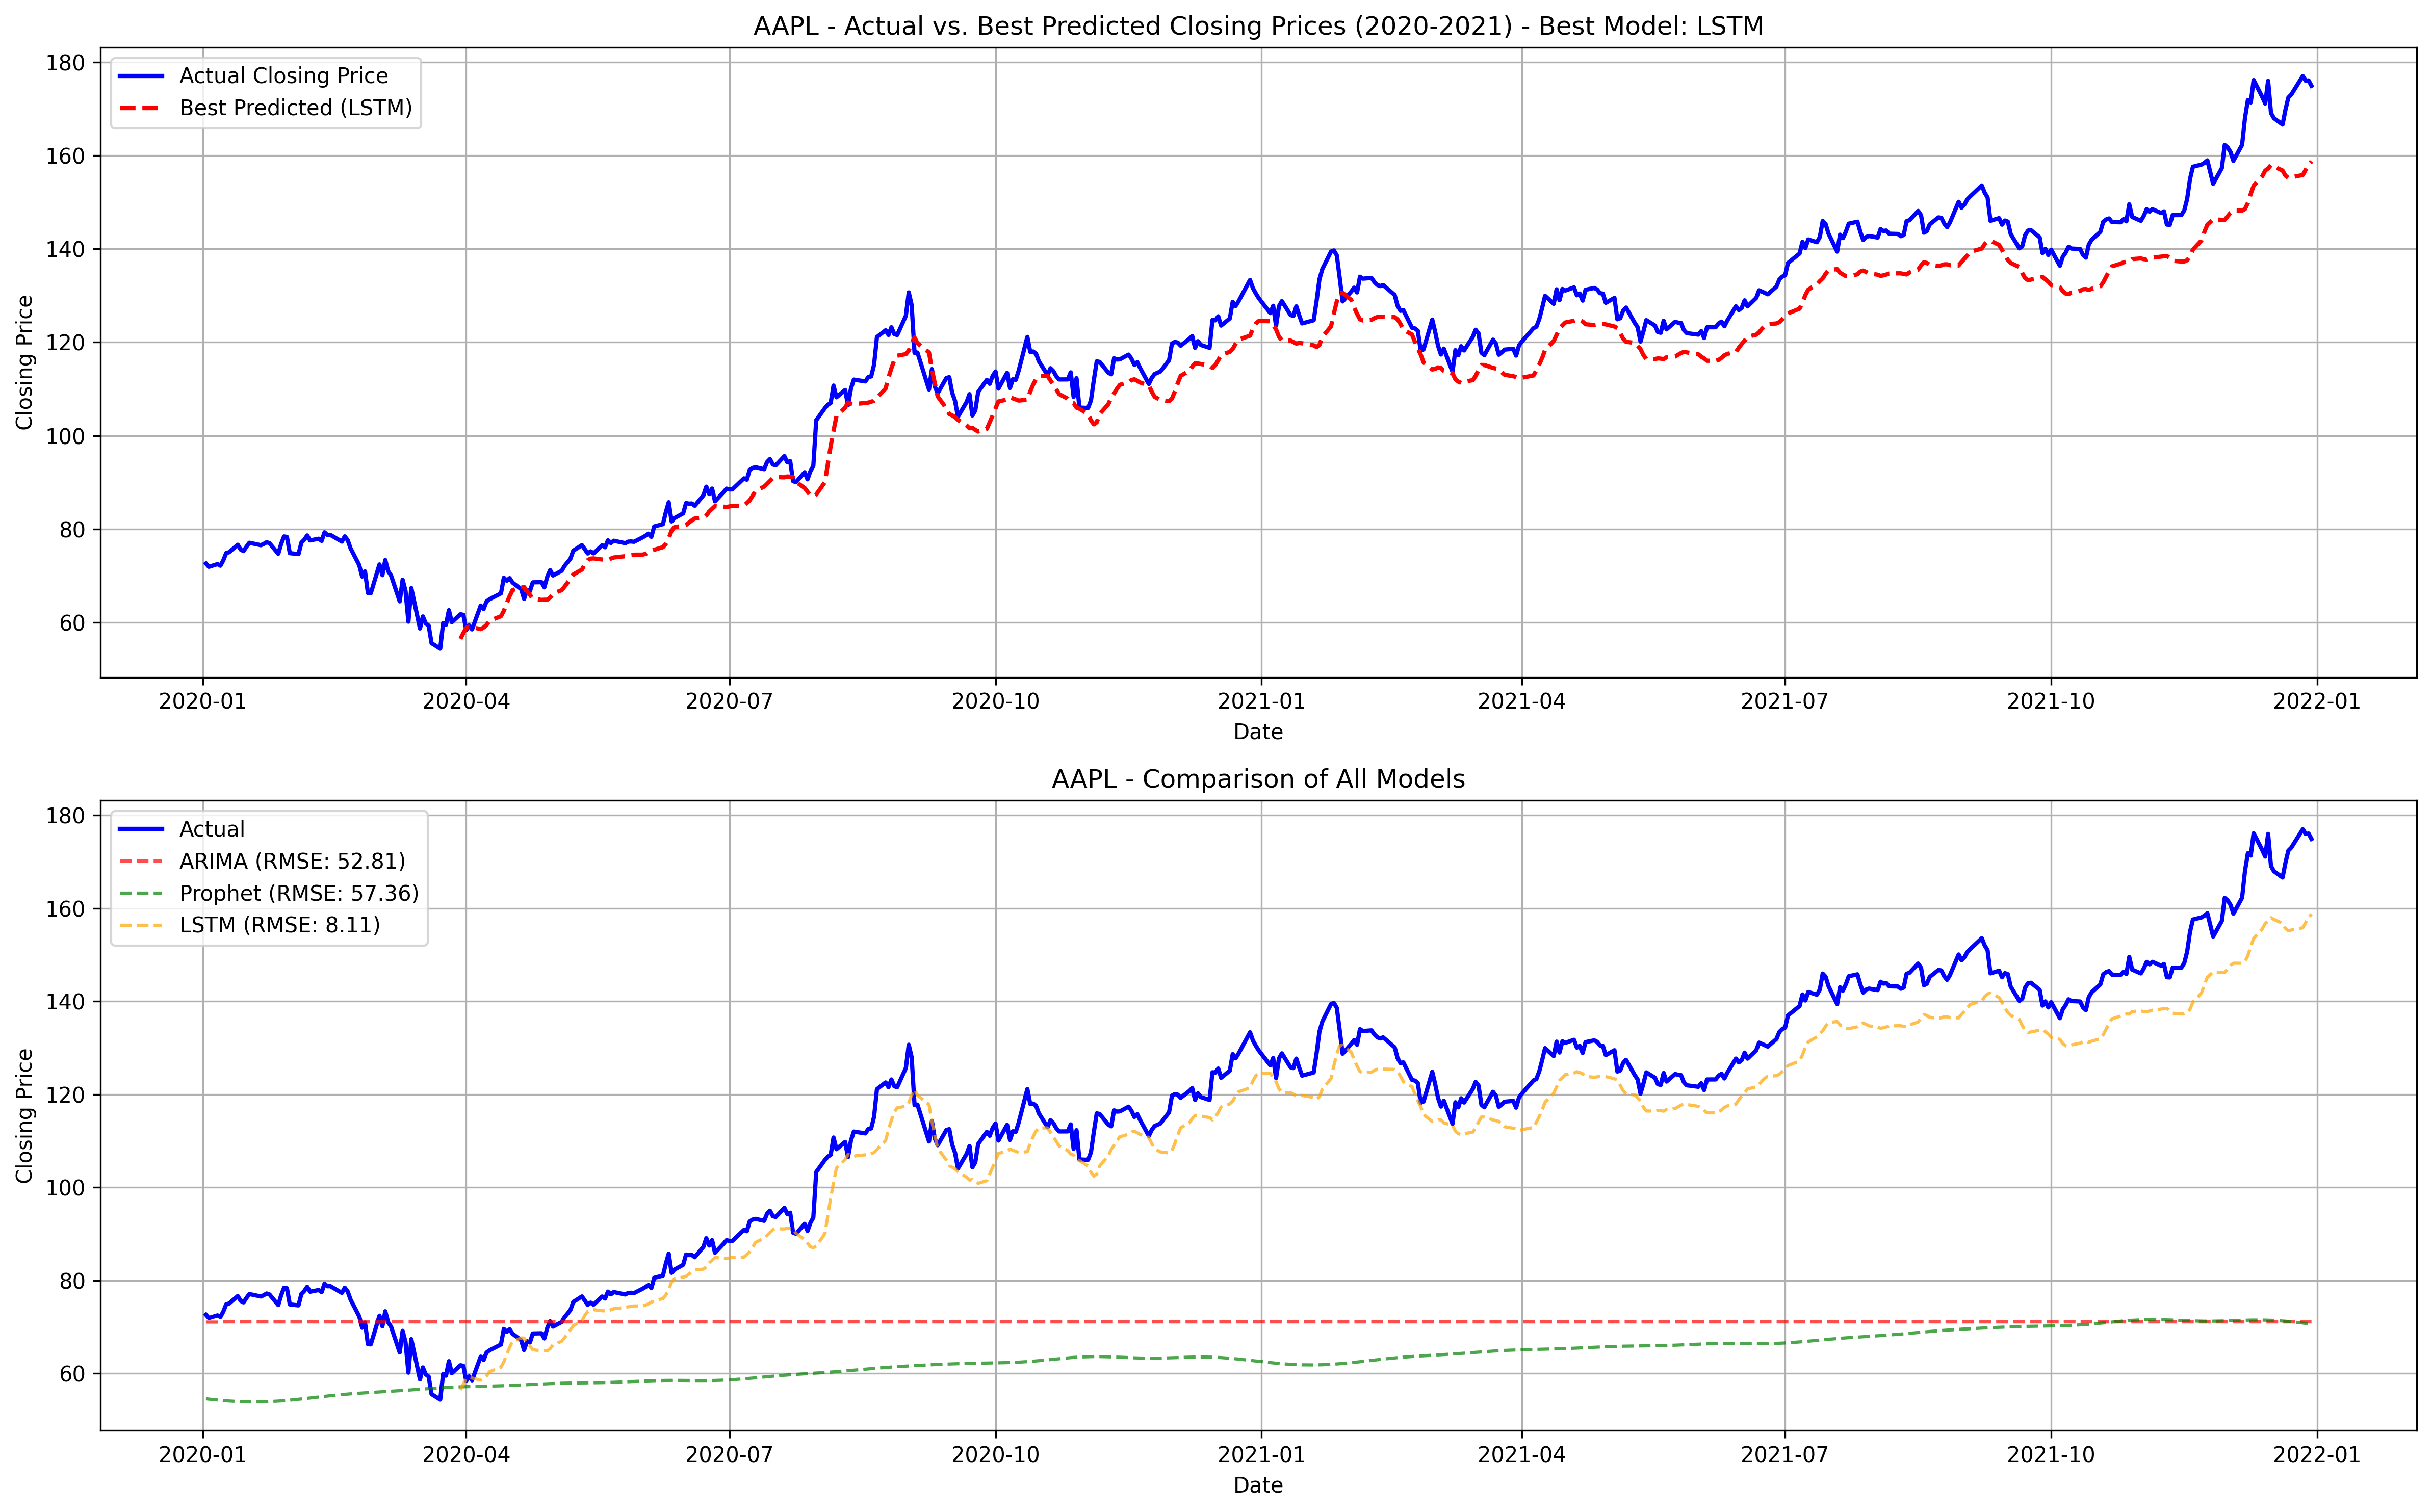

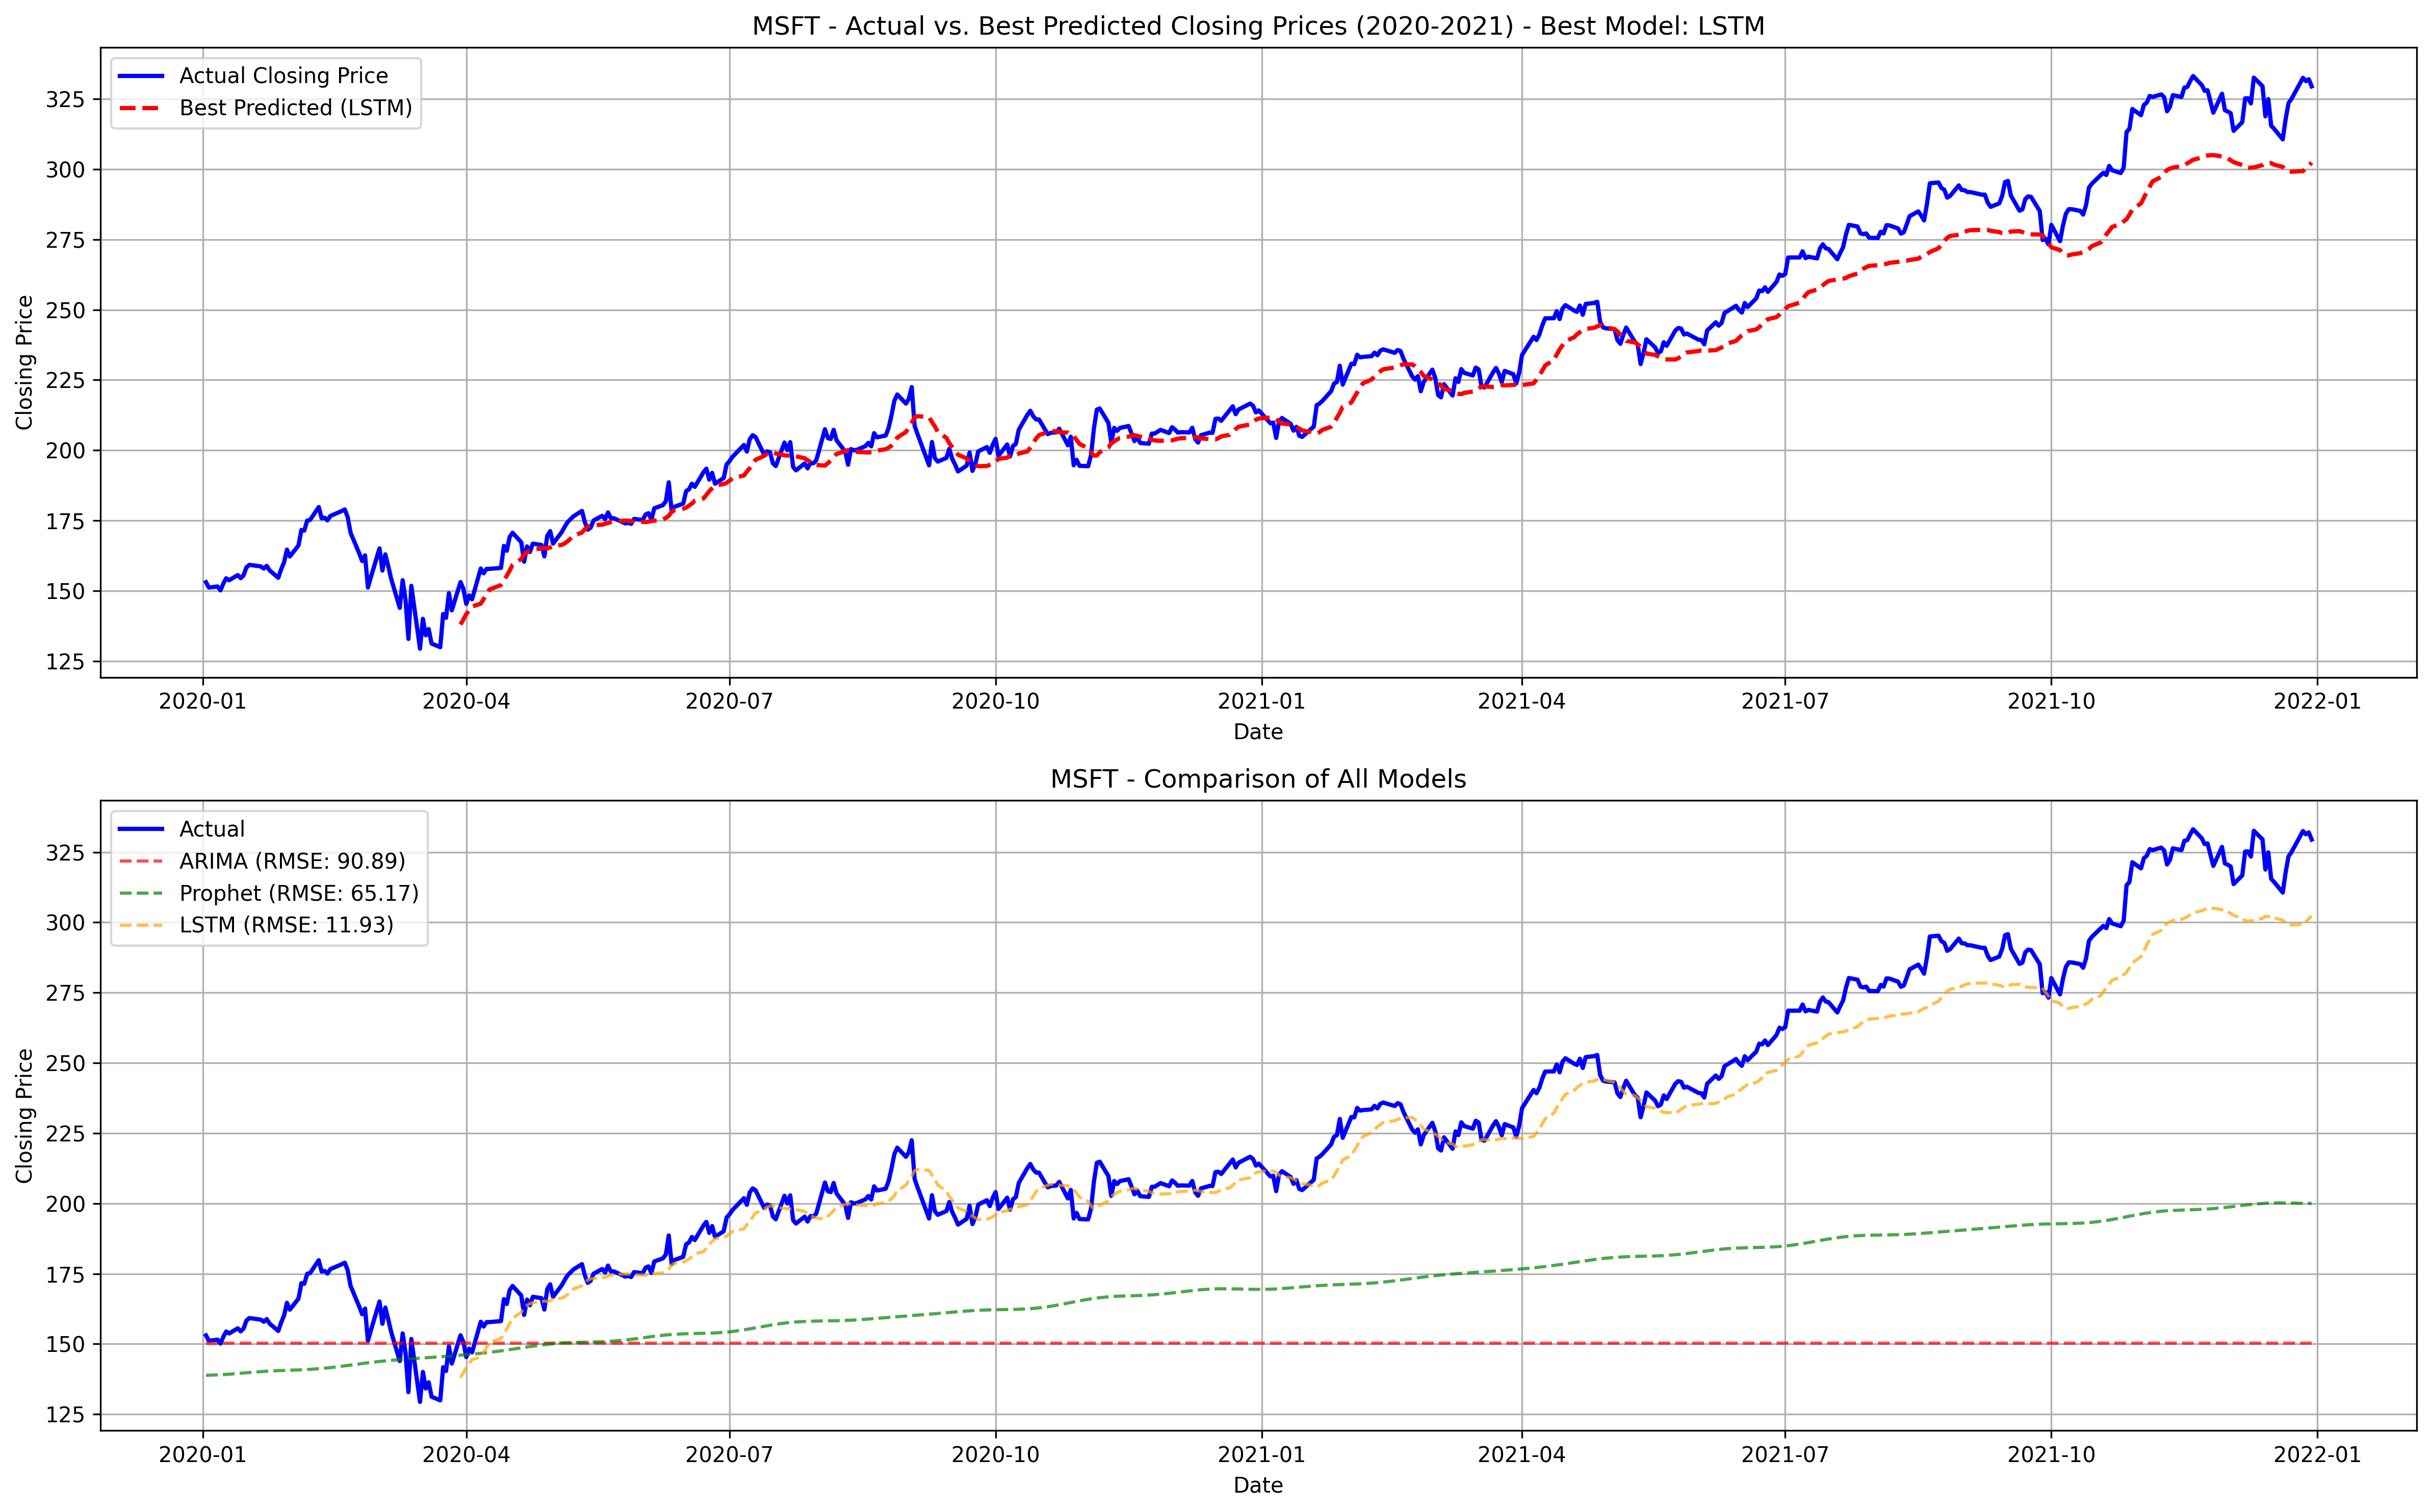

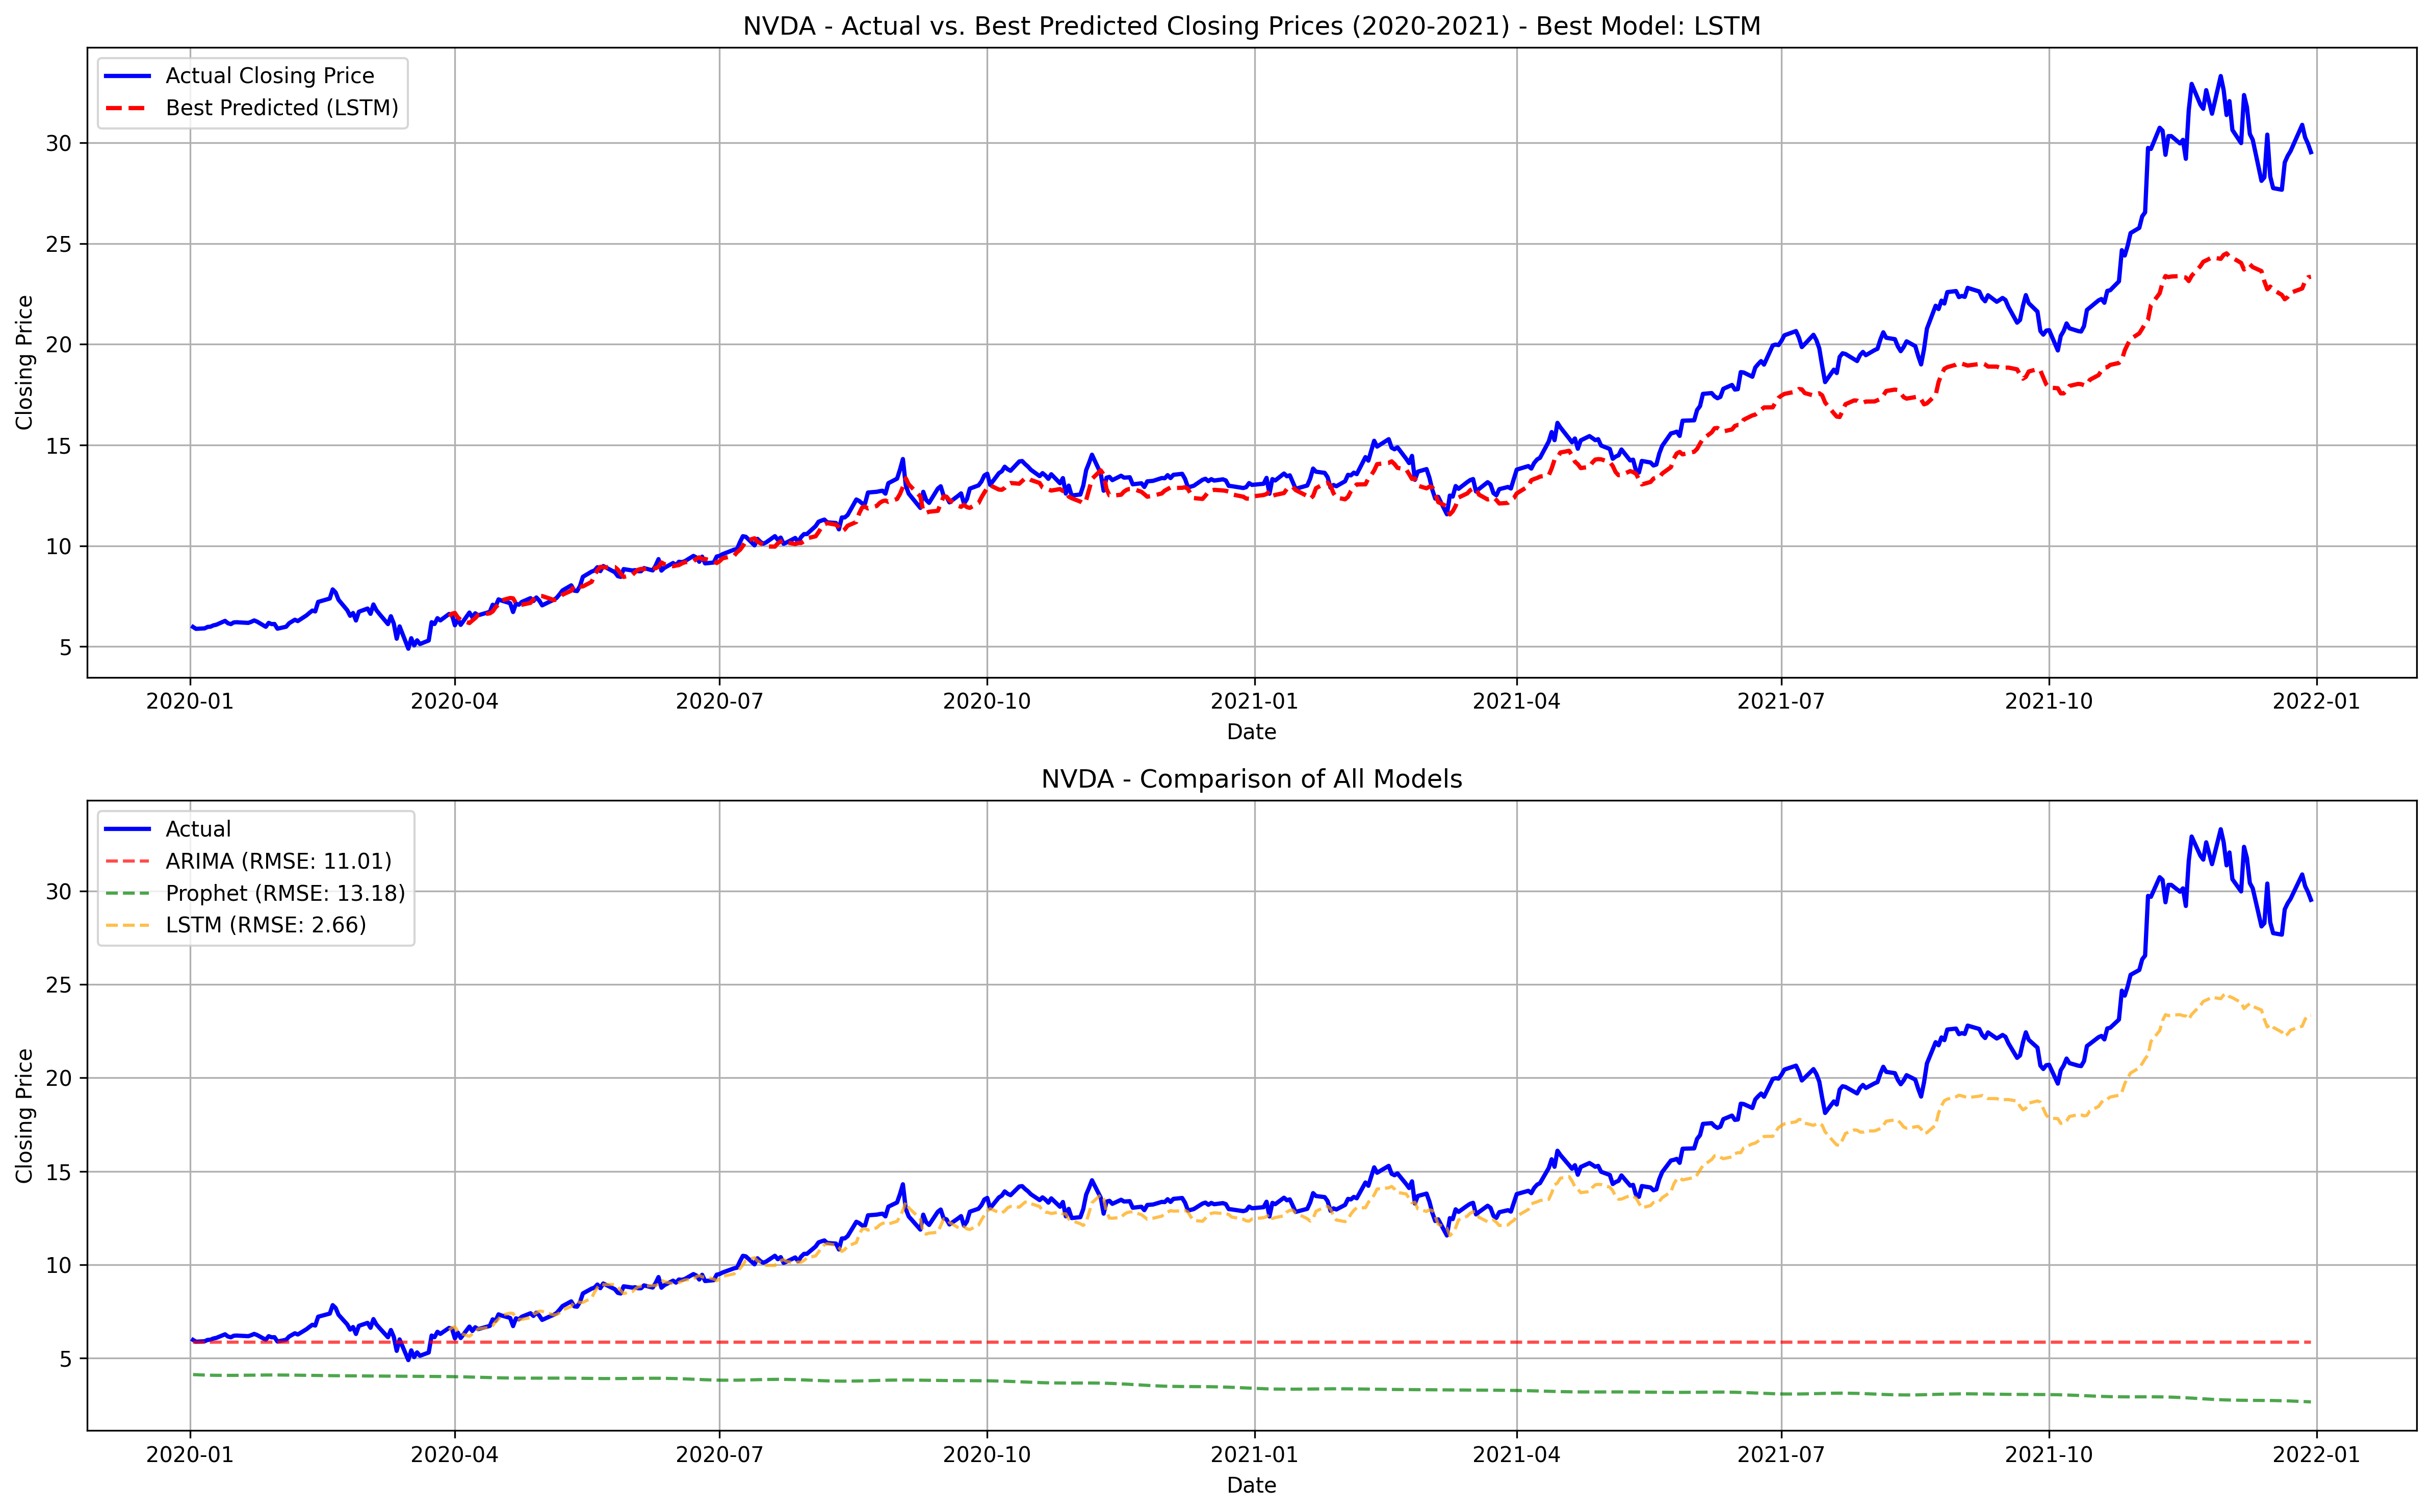

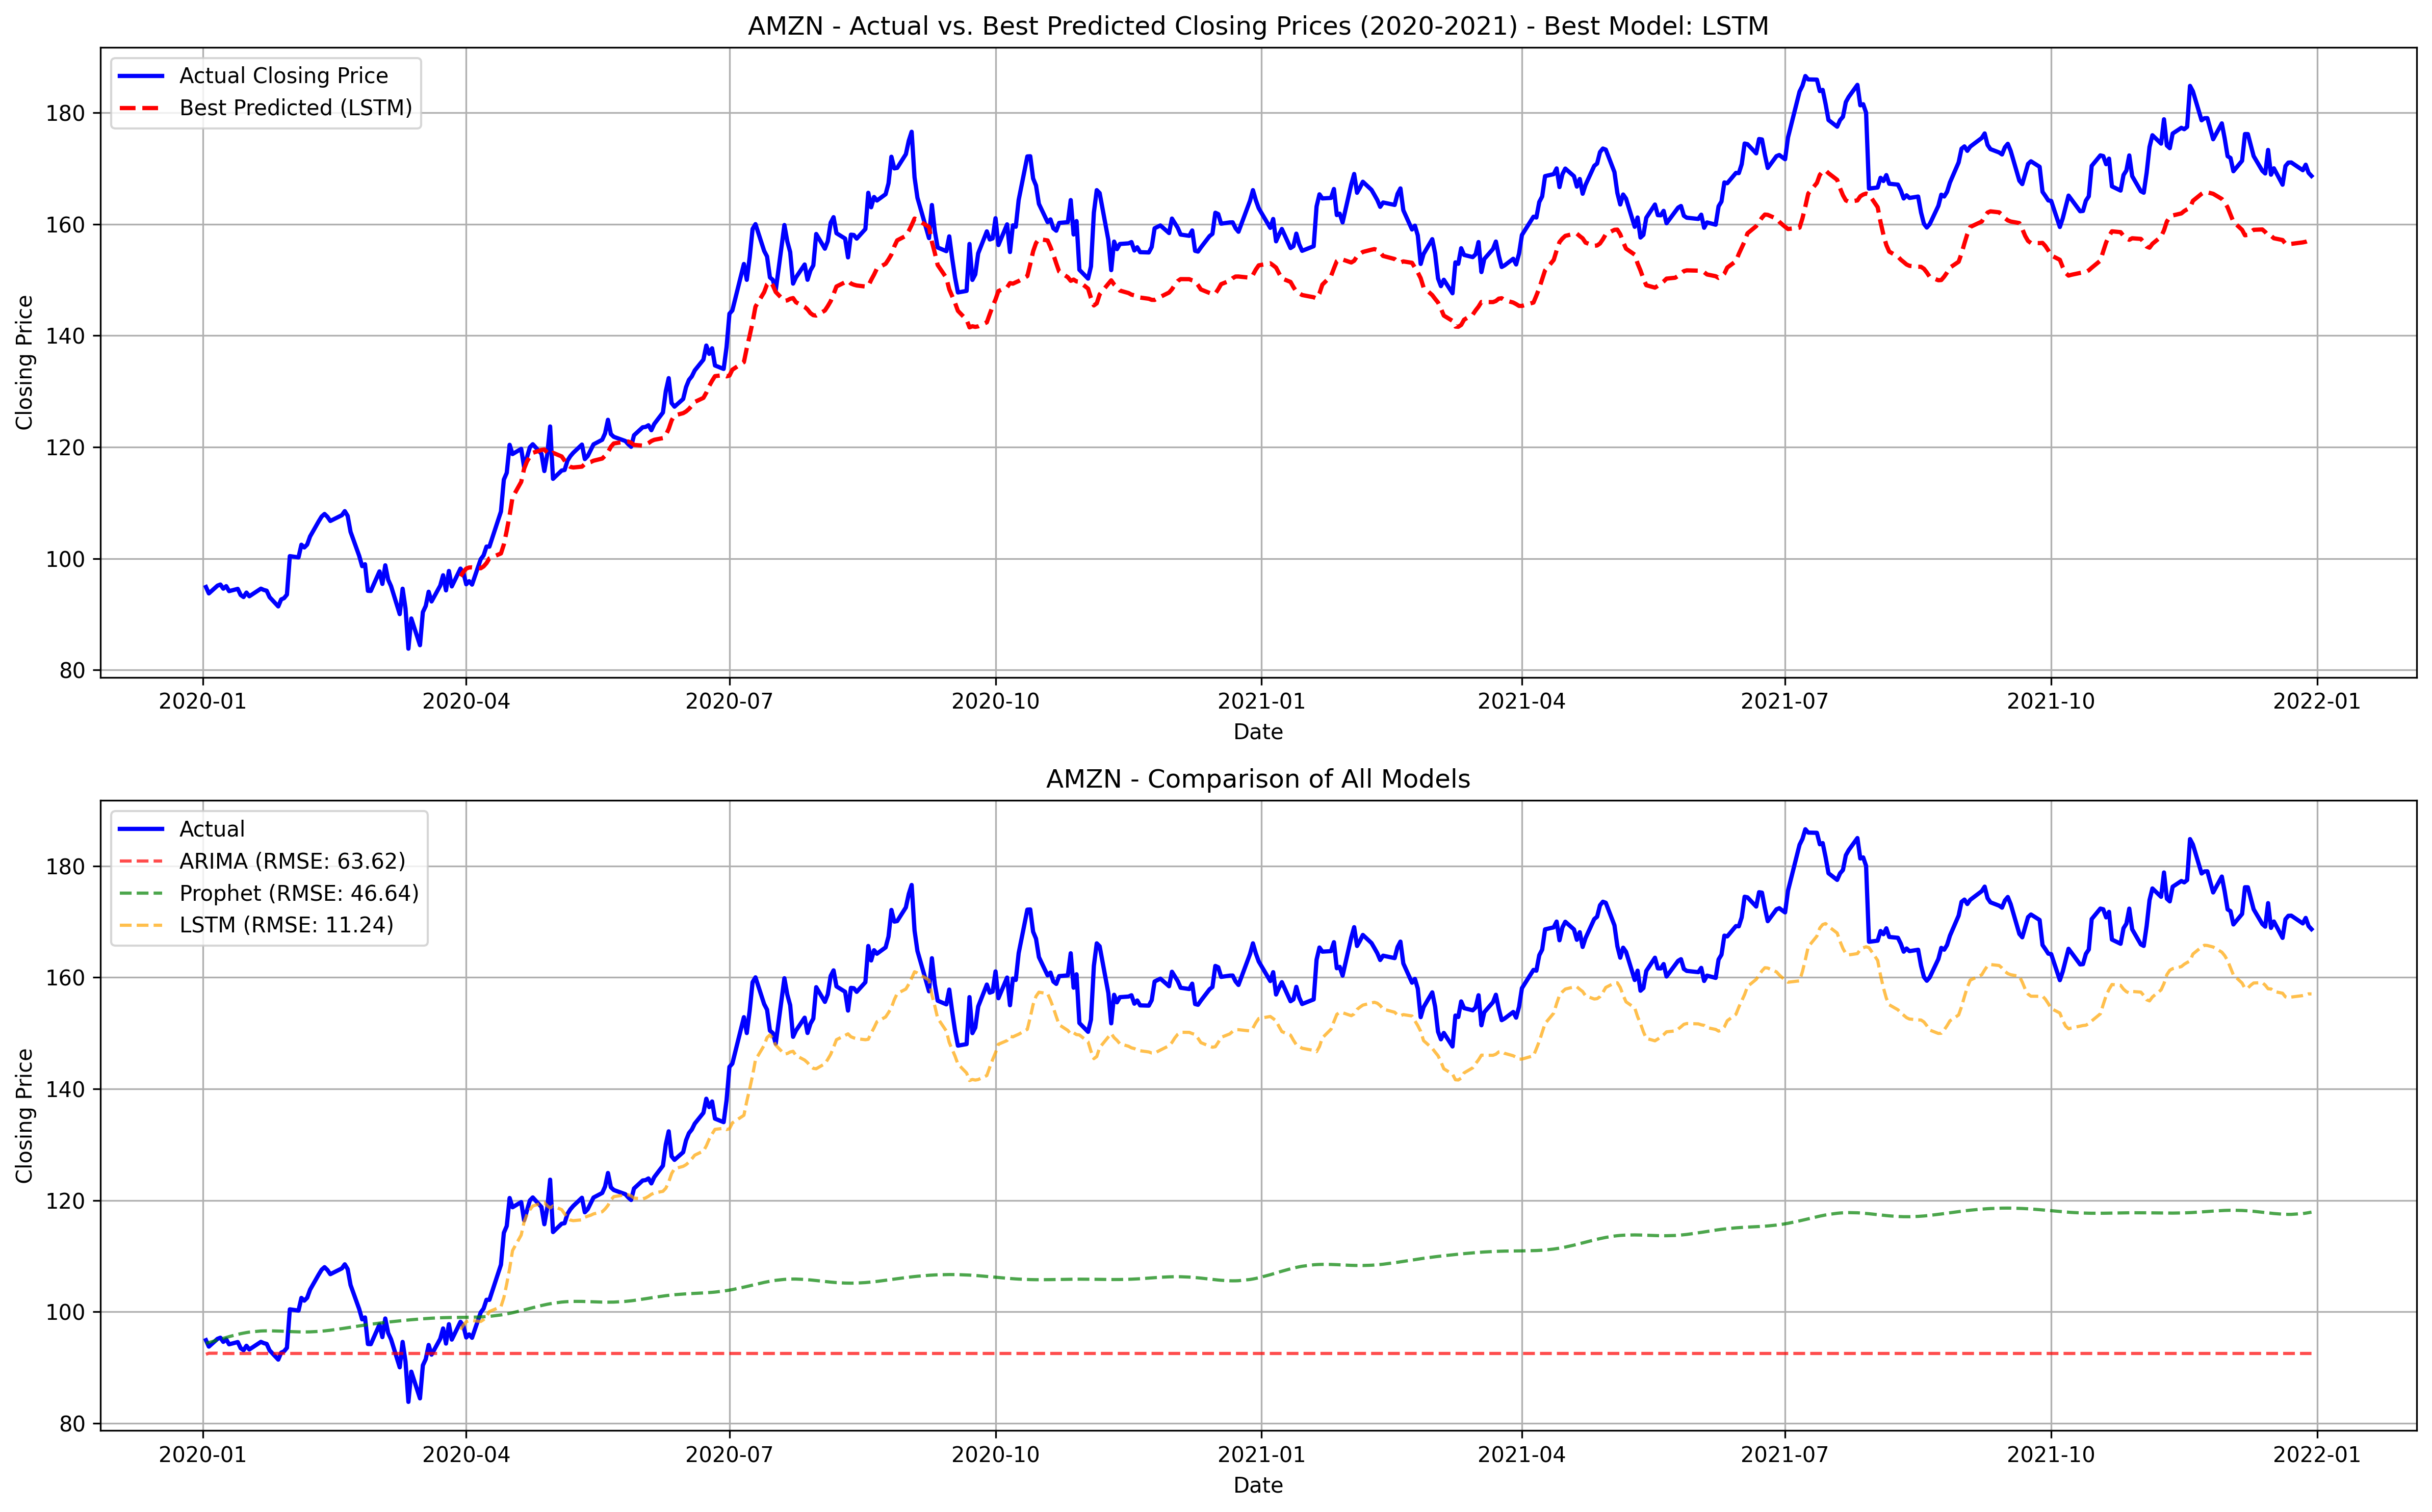

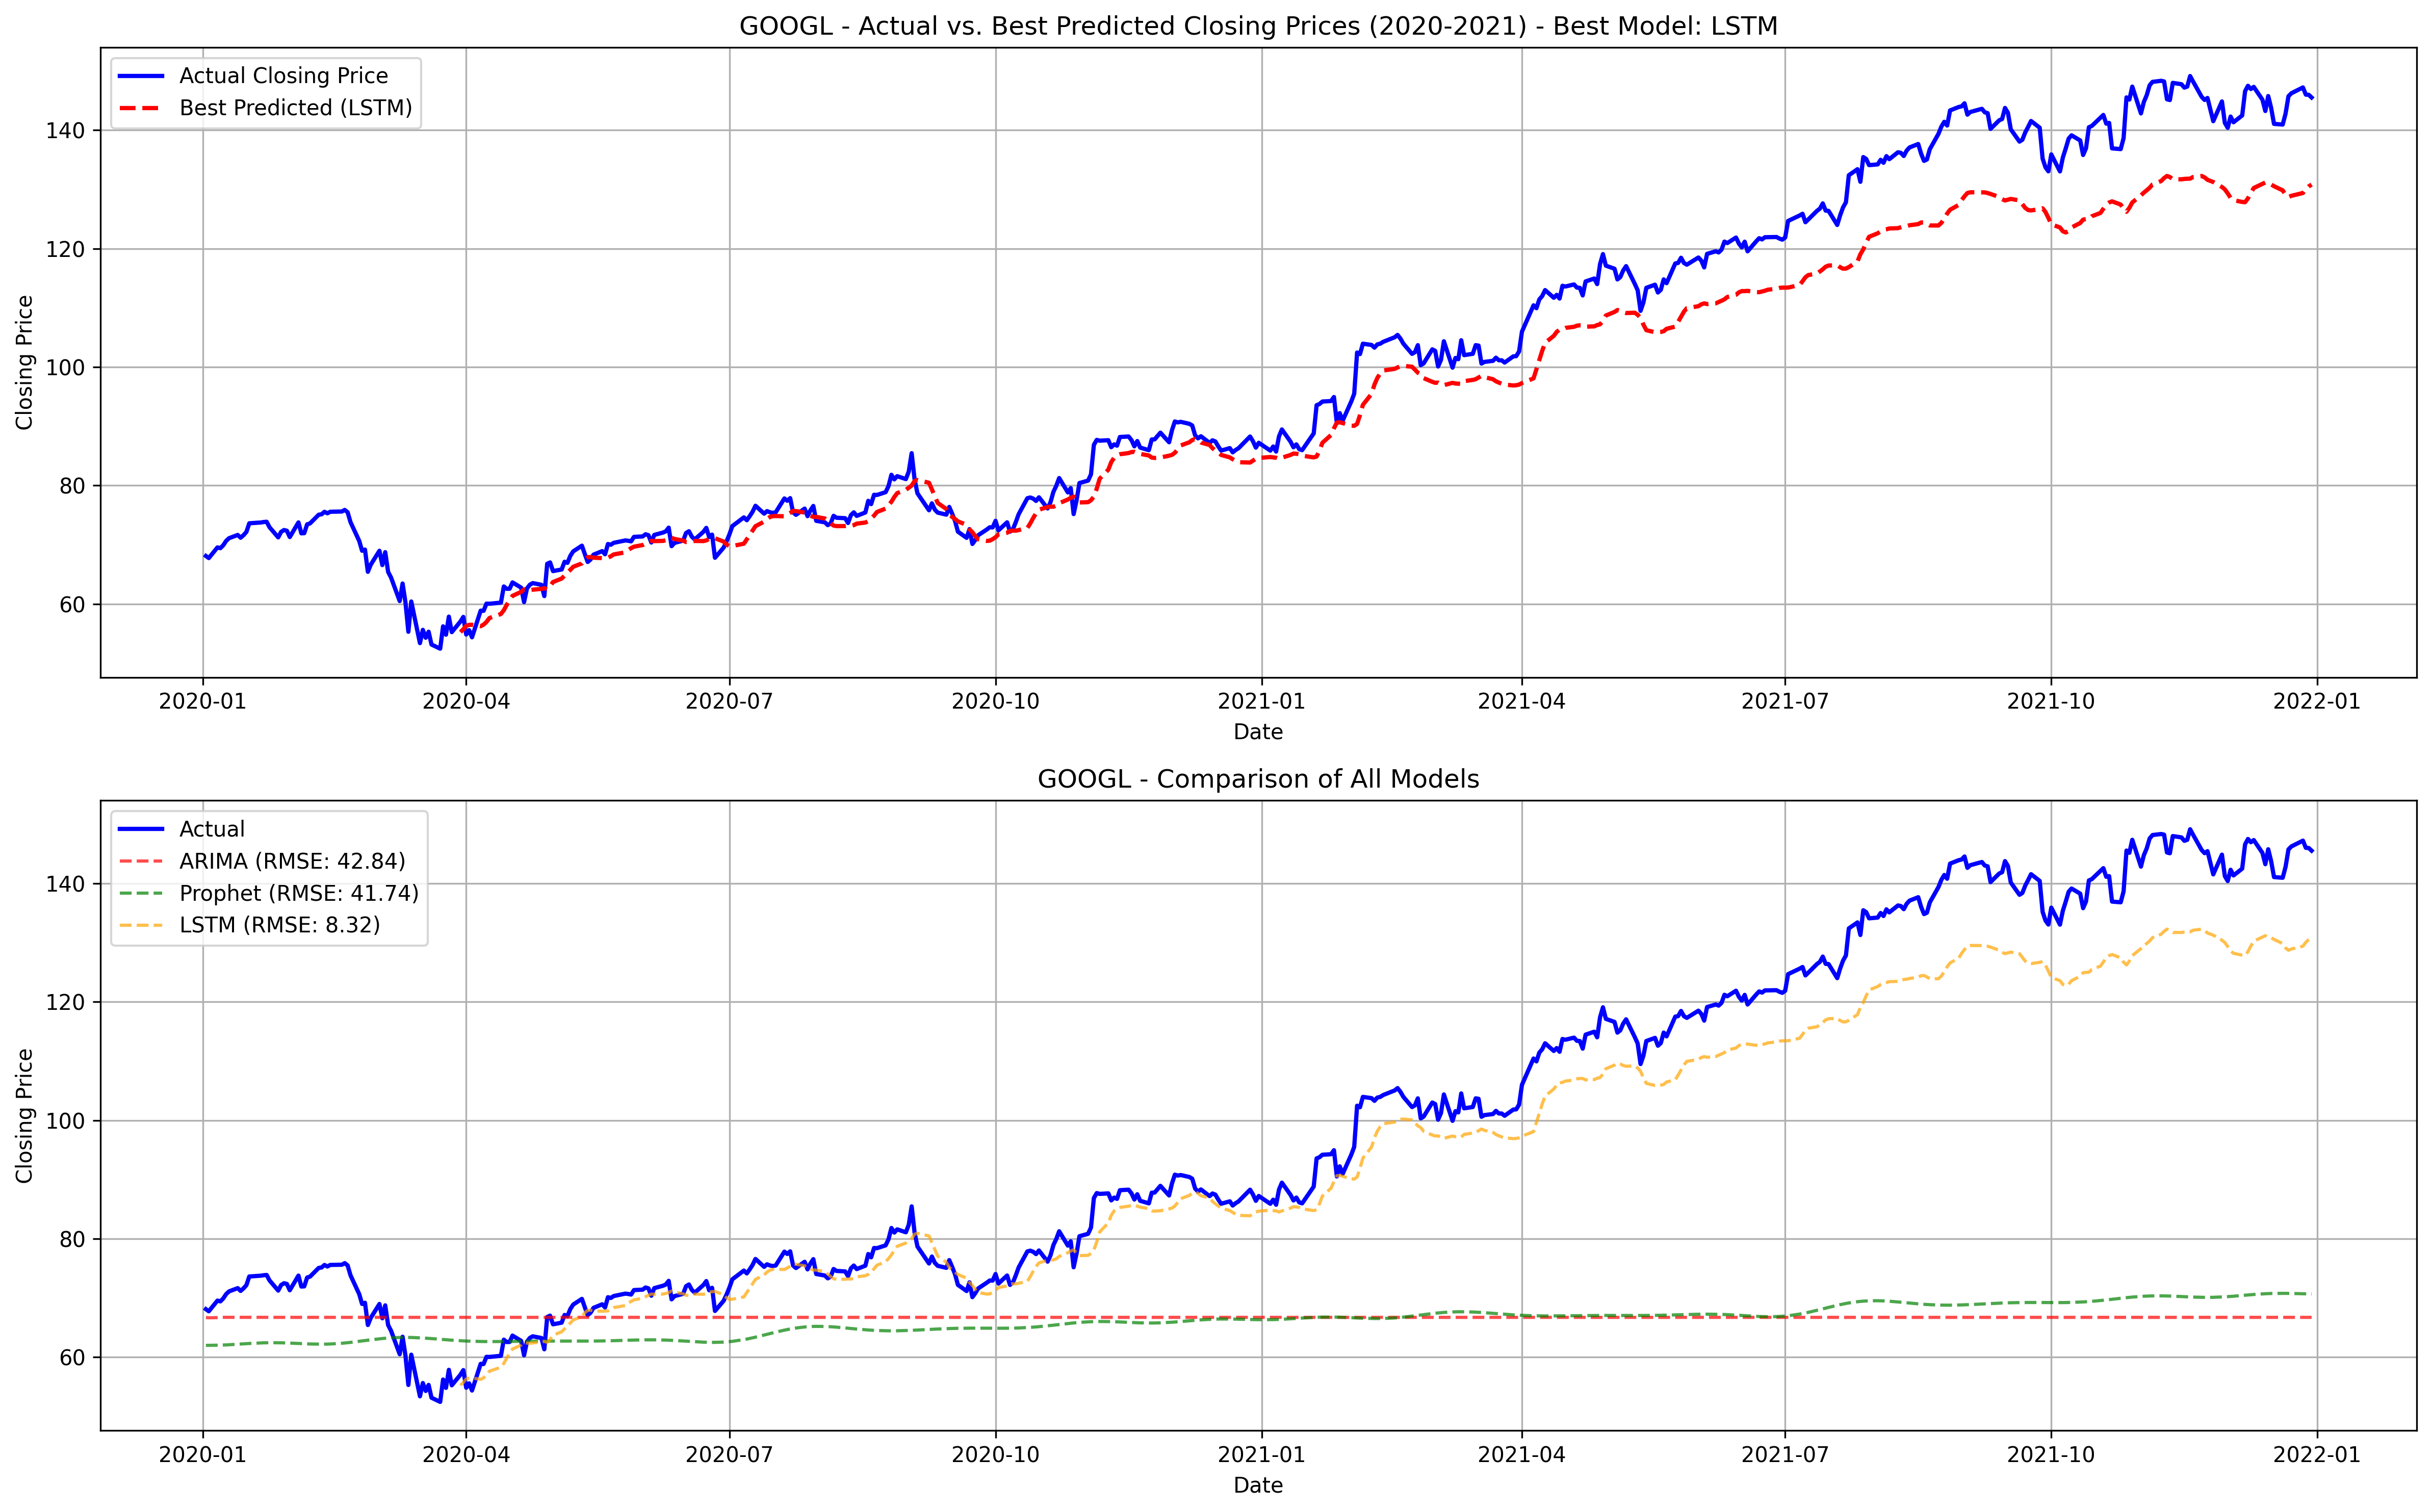

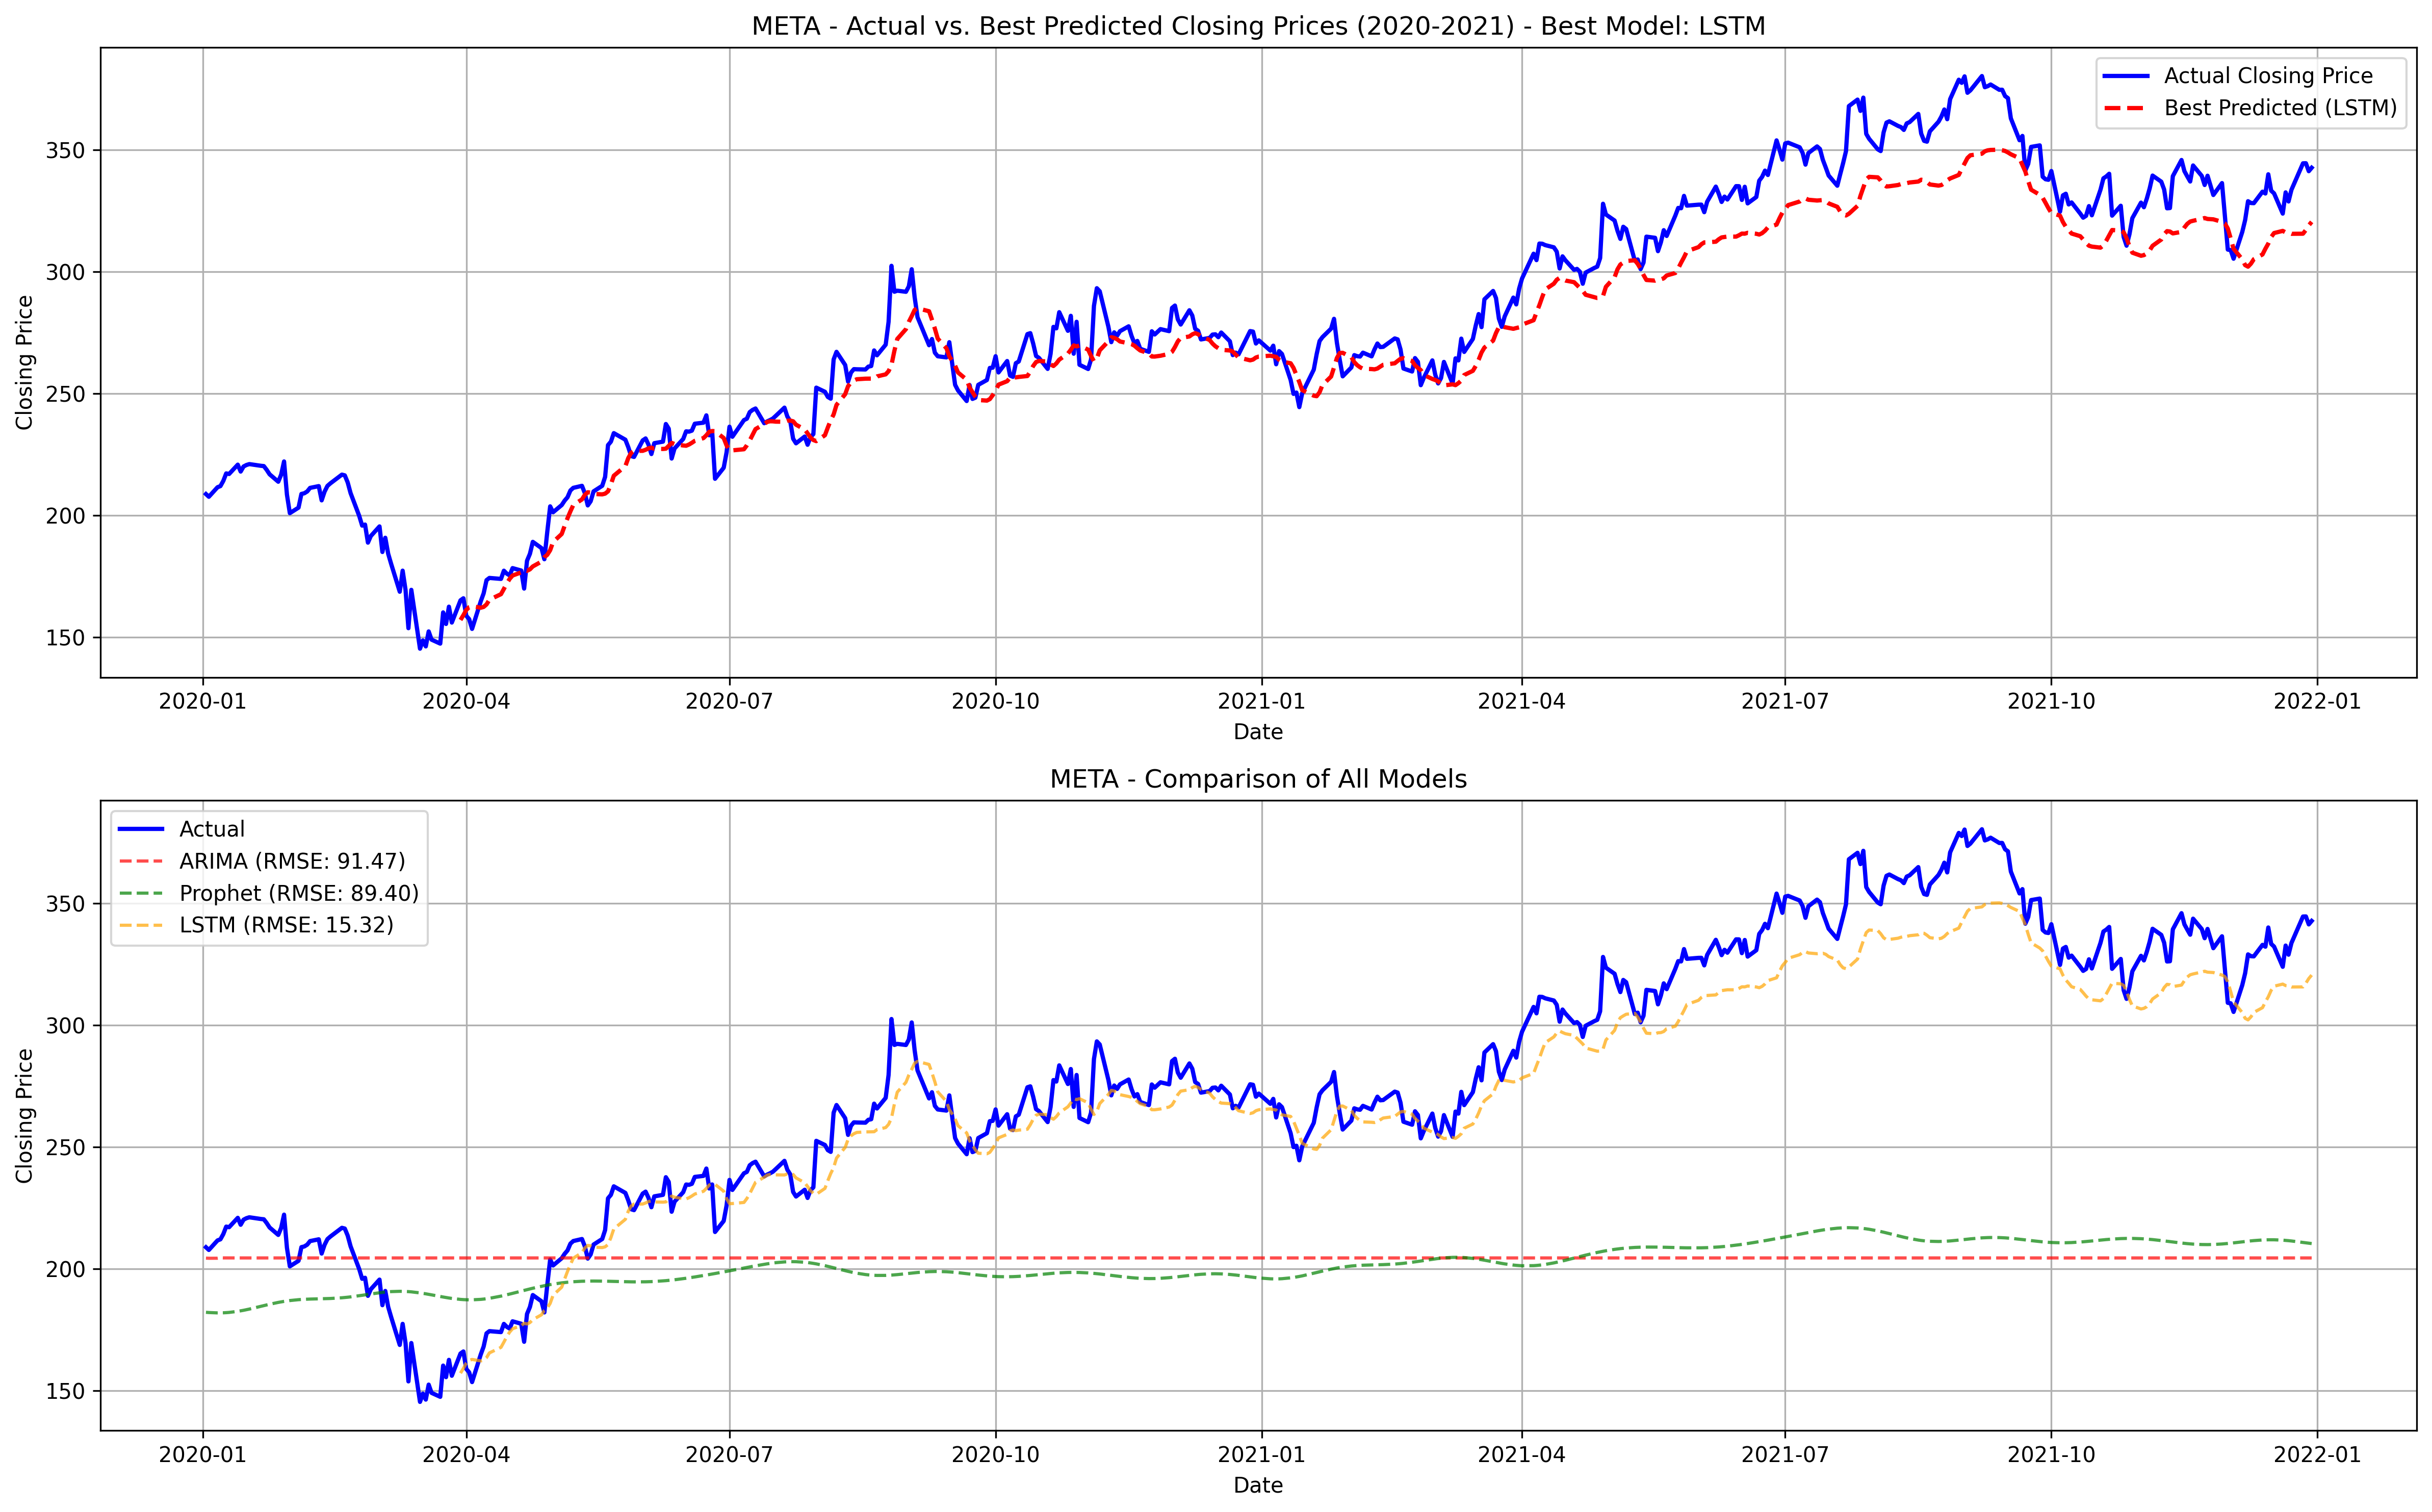

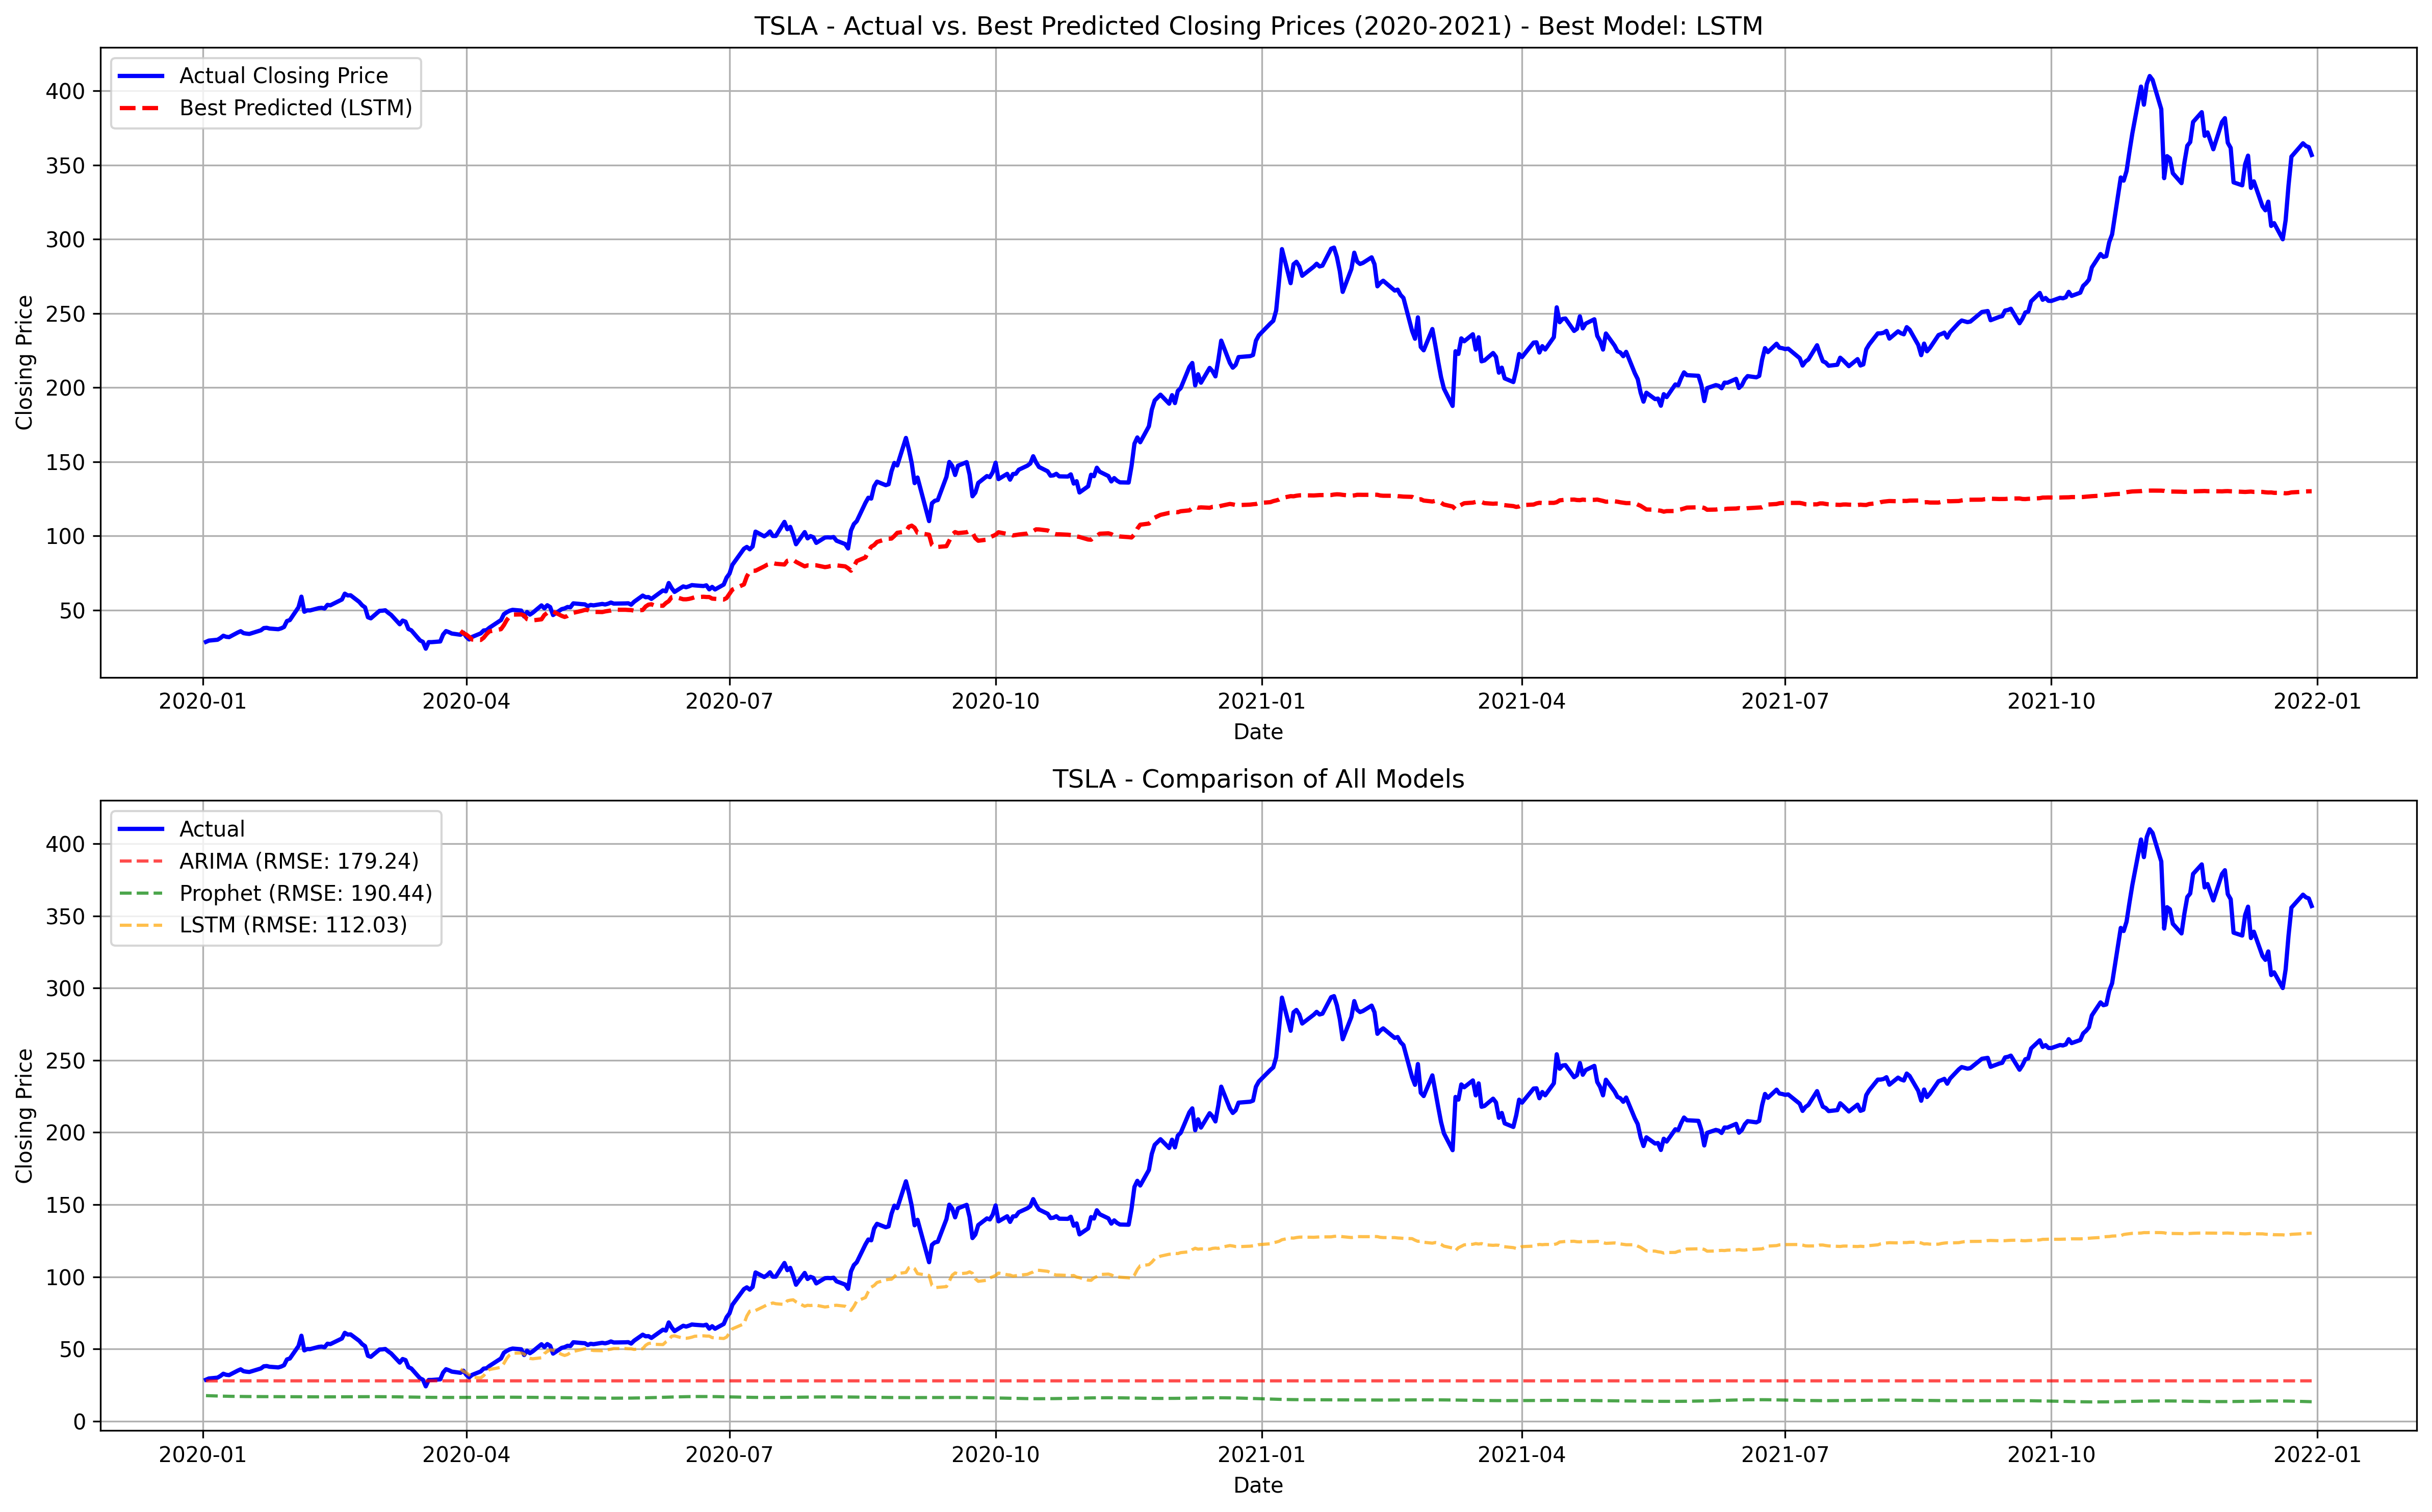

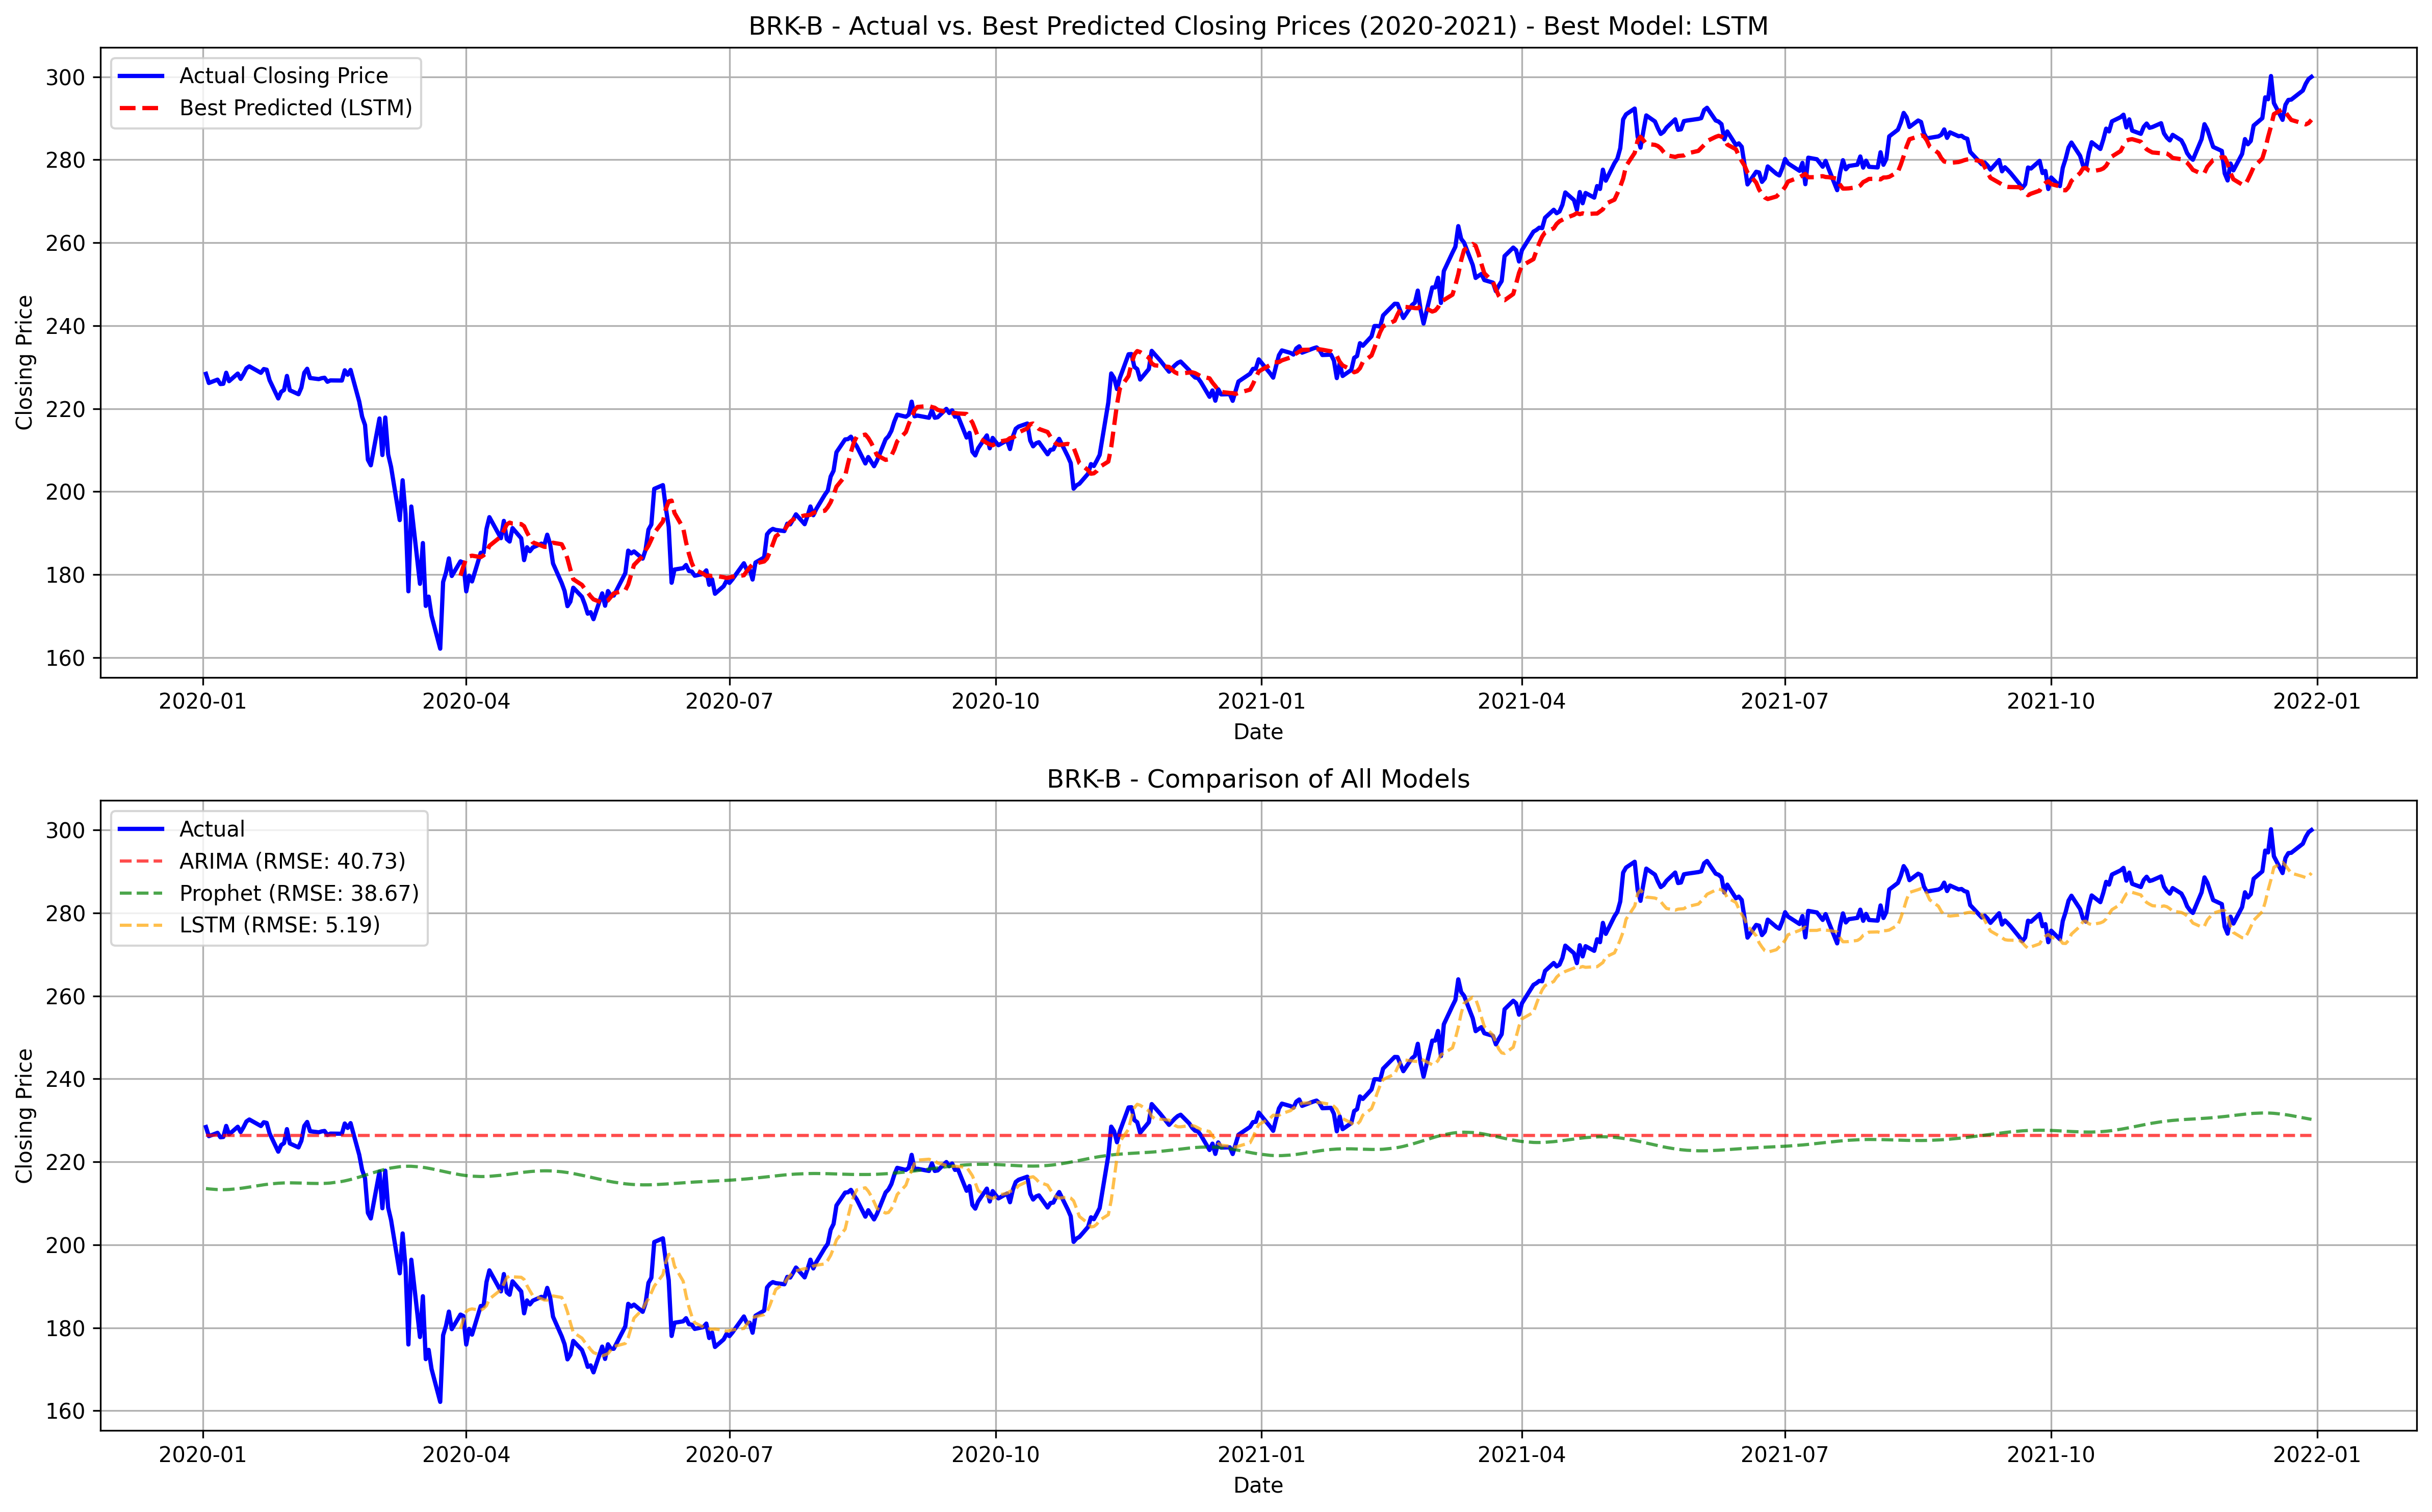

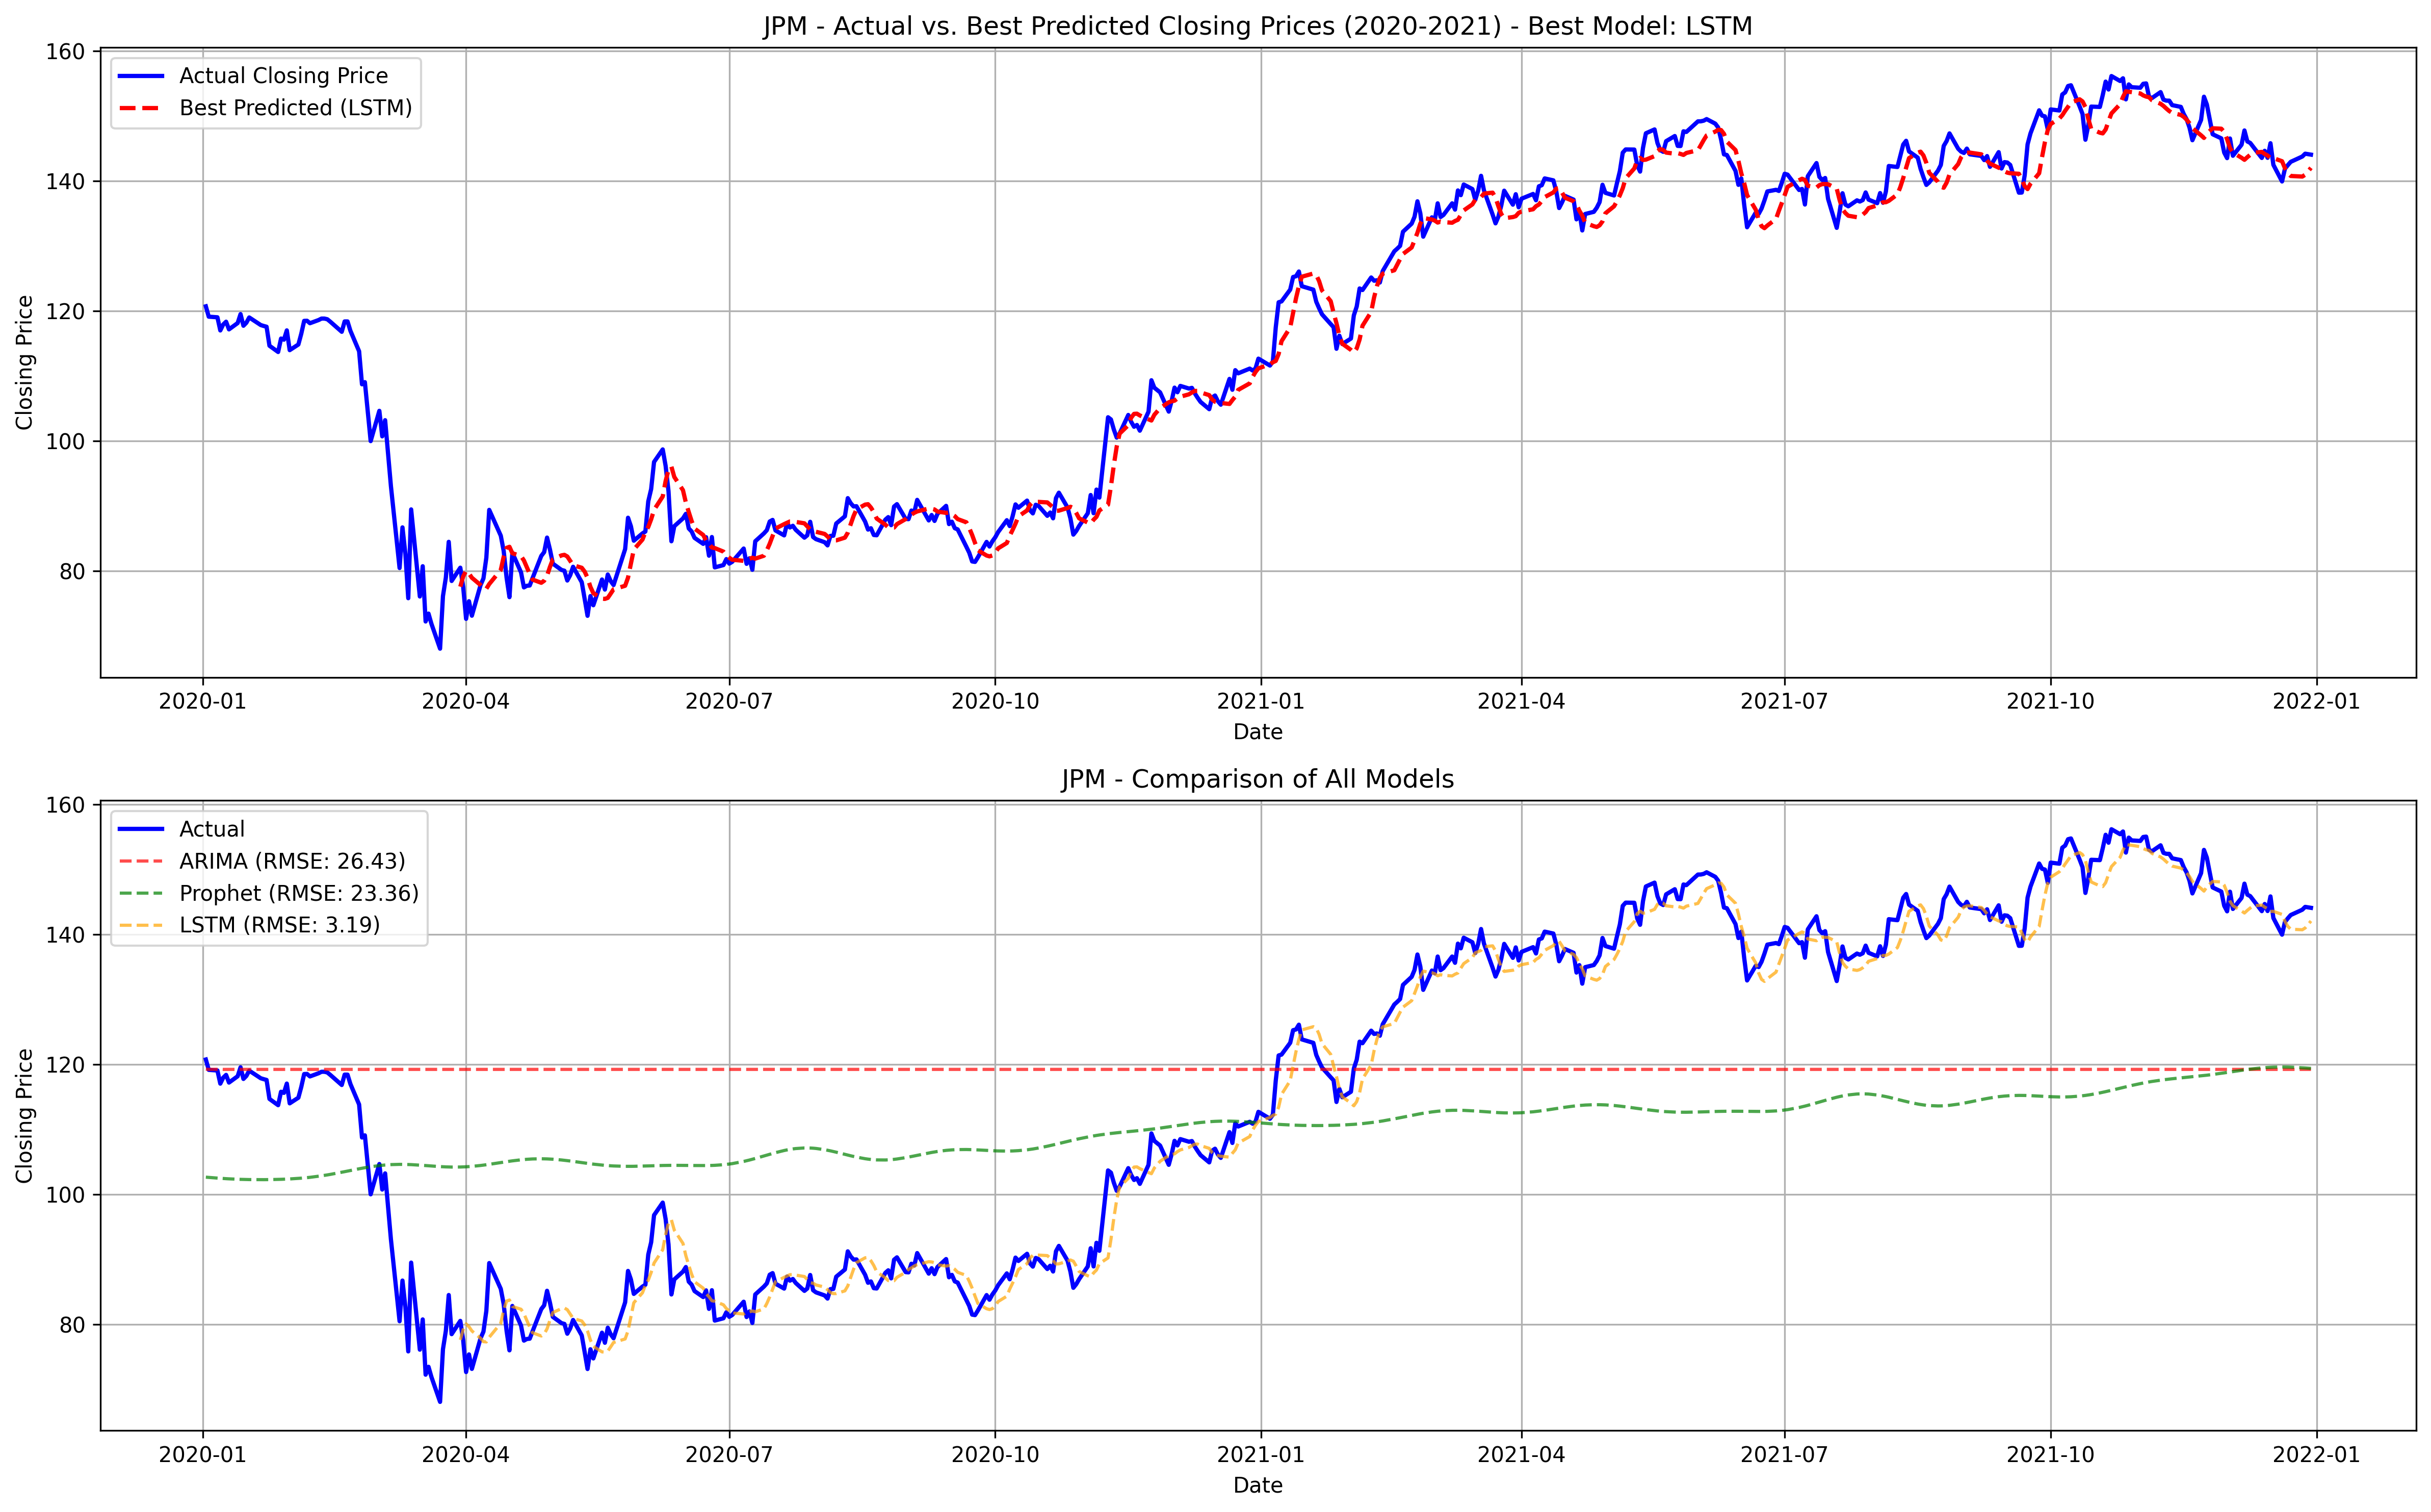

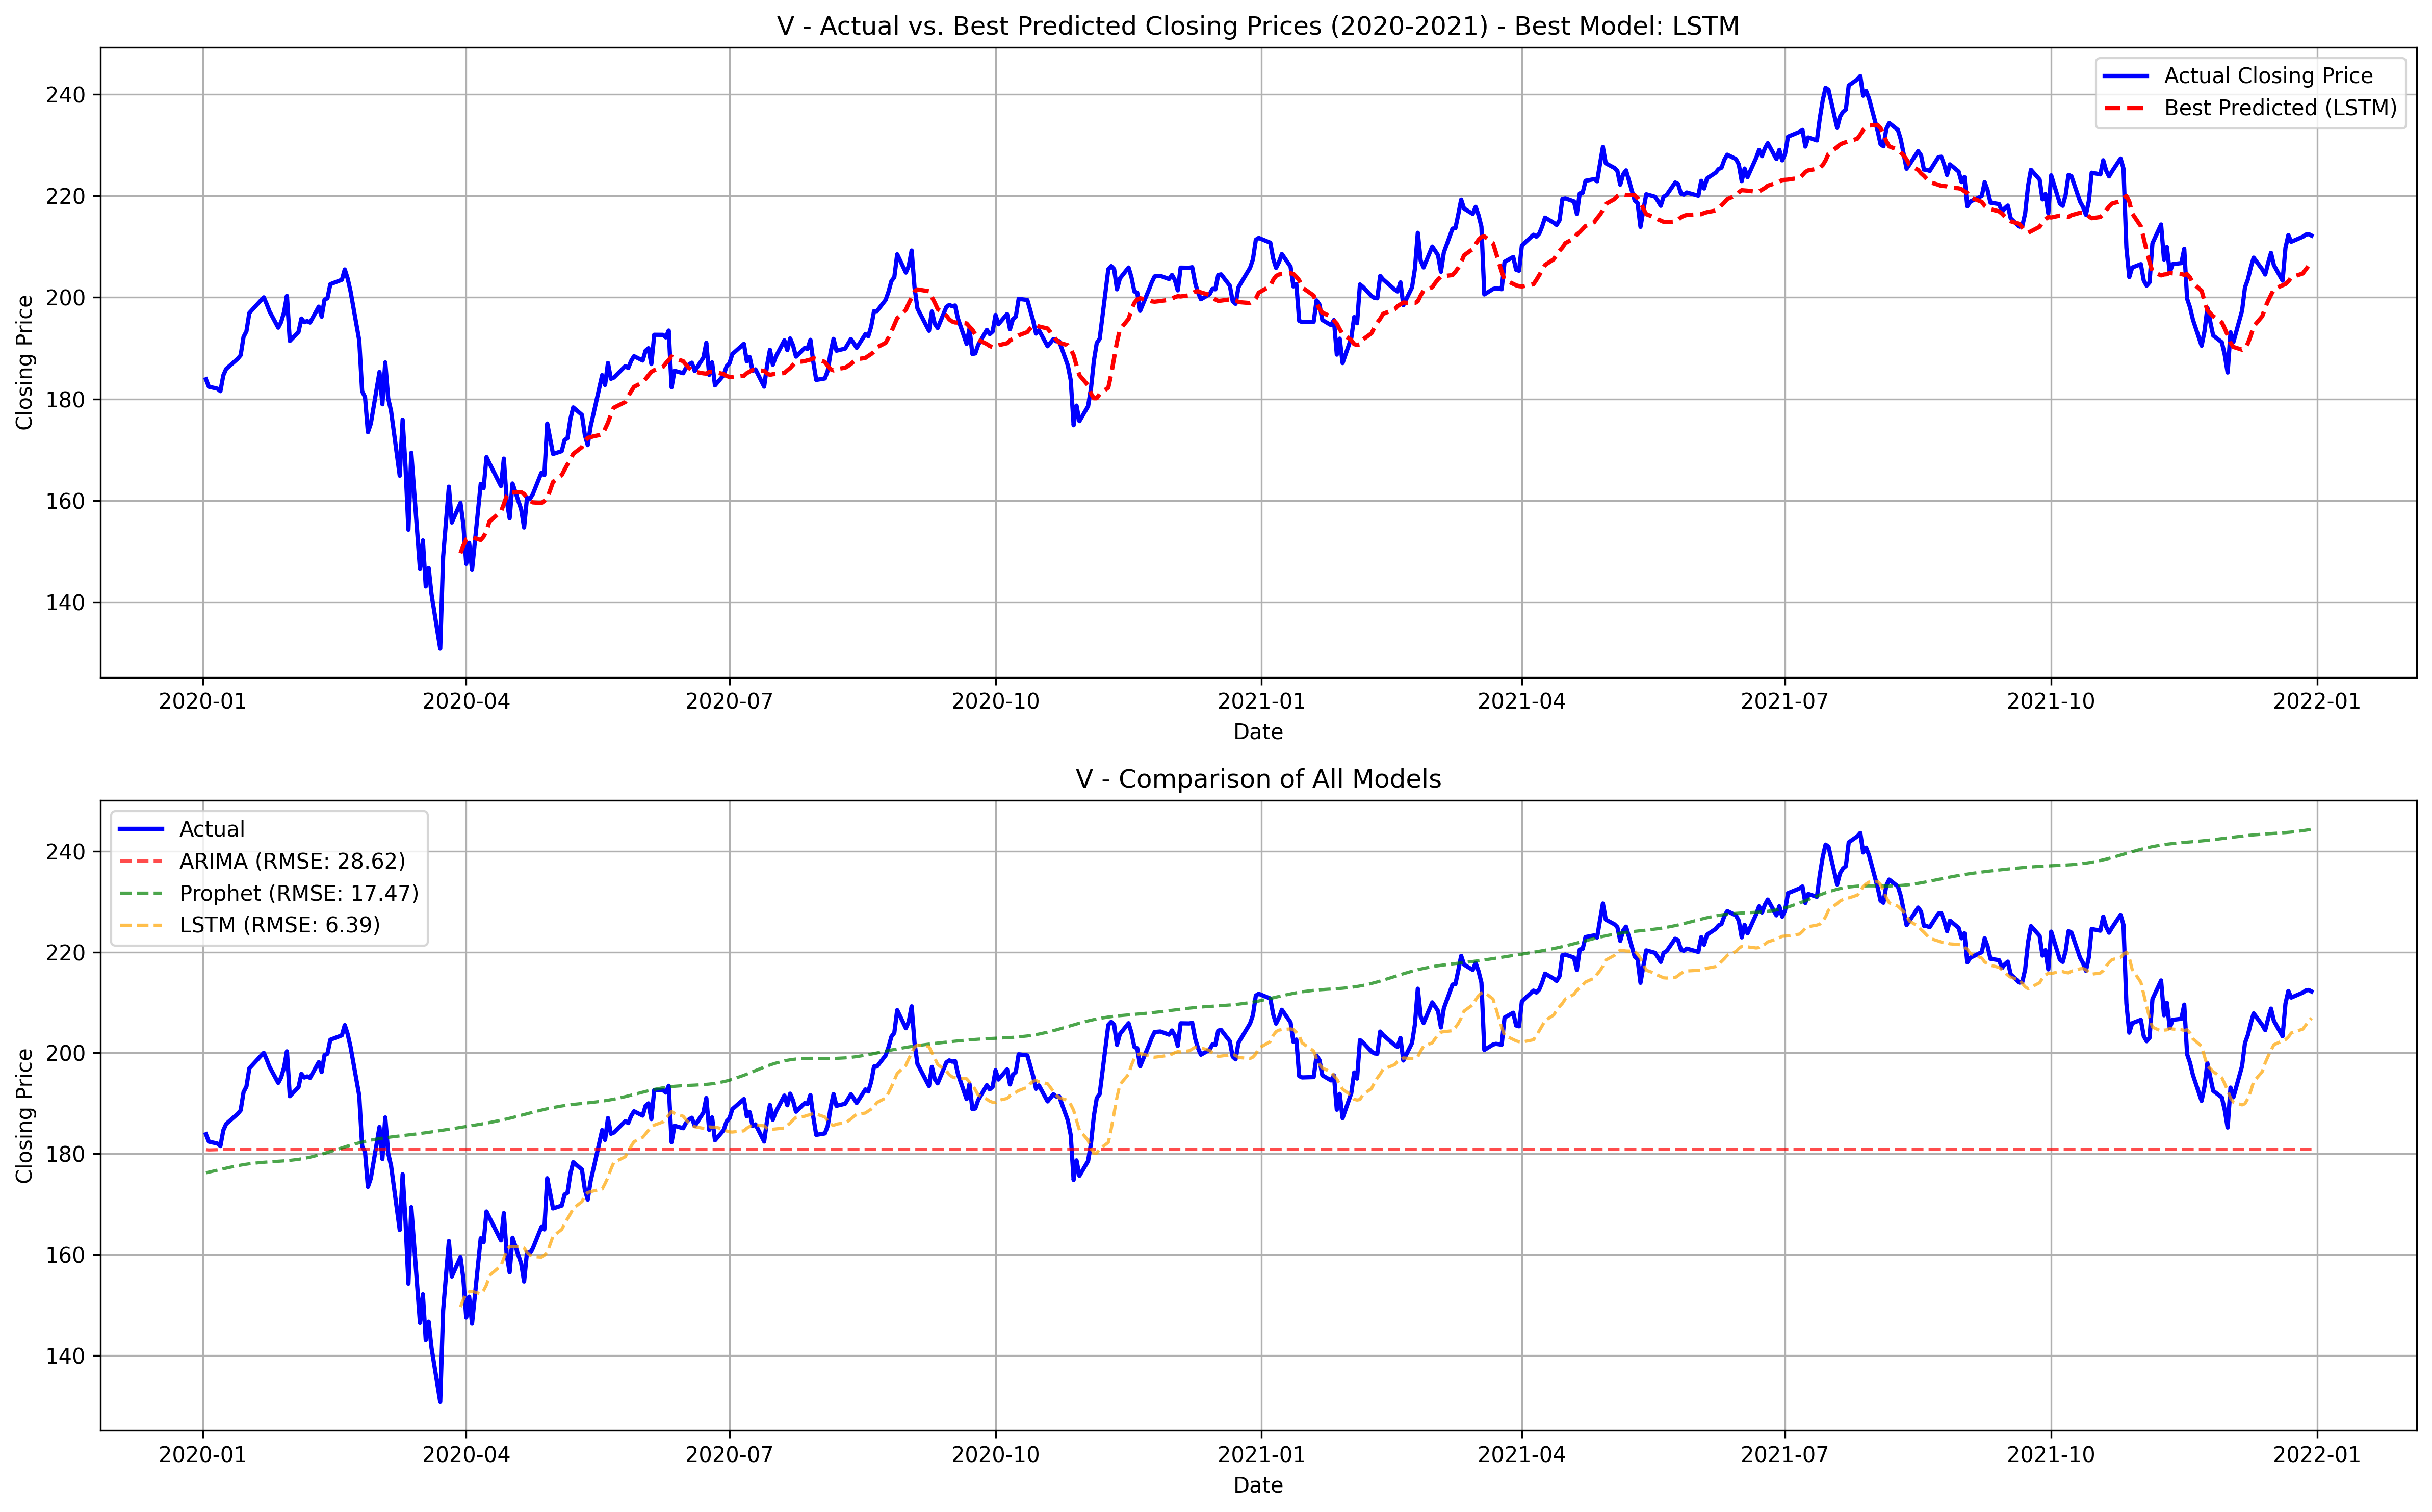

In [3]:
from IPython.display import Image, display

tickers = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-B', 'JPM', 'V']

for ticker in tickers:
    filename = f'/content/{ticker}_stock_prediction.png'
    try:
        display(Image(filename=filename))
    except Exception as e:
        print(f"Could not display {filename}: {e}")
